### AFJ Limited Agent

We are building an agent for AFJ Limited, it is a company that specializeing is routing softwarre and fleet management. The goals of the agent is to be able to:
- Analyse data from the dataframe to provide insight about the dataset
- Use the Python REPL tool to run python code on the data provided and visualize the data.
- Use machine learning models which are provided as tools to answer questions about the result from the dataset

##### Ingest and create contigous dataset

The first step is to read the data from csv files and convert them into a single datafram

In [1]:
import os

files = os.listdir("./data/")

In [2]:
number_of_files = len(files)

In [3]:
import random

In [4]:
file = files[random.randint(0, 10)]
keys = file.split(".")[0].split("_")

In [5]:
print(keys), print("number of keys are ", len(keys))

['2017-07-14', 'Seat', 'Leon', 'KA', 'KA', 'Frei']
number of keys are  6


(None, None)

In [6]:
translation_map = {
    "Stau": "Traffic",
    "2 Normal": "Normal",
    "Normal": "Normal",
    "Stau Messfehler": "Traffic Jam Measurement error",
    "Frei": "Free",
    "Frei Vollbremsung": "Emergency Braking",
    "Normal Glatteis": "Normal Icy Road",
    "Frei Beschleunigung": "Free Accelaration",
    
}

In [7]:
import pandas as pd

df = None

for file in files:
    if file.endswith(".csv"):
        # extract key data
        keys = file.split(".")[0].split("_")
        date = keys[0]
        brand = keys[1]
        model = keys[2]
        source = keys[3]
        destination = keys[4]
        if(len(keys) == 6):
            condition = translation_map[keys[5]]
        elif (len(keys)==7):
            condition = translation_map[" ".join([keys[5], keys[6]])]
        else:
            raise Exception(f"Keys from file exceded amounnt that was sheduled to be processed \n keys: {keys} \n number of keys {len(keys)} \n We can only process 6 or 7 keys")

        # read file and create dataframe
        if df is not None:
            new_df = pd.read_csv(os.path.join("data", file))
            new_df["date"] = date
            new_df["brand"] = brand
            new_df["model"] = model
            new_df["source"] = source
            new_df["destination"] = destination
            new_df["condition"] = condition
            df = pd.concat([df, new_df])
        else:
            df = pd.read_csv(os.path.join("data", file))
            df["date"] = date
            df["brand"] = brand
            df["model"] = model
            df["source"] = source
            df["destination"] = destination
            df["condition"] = condition
    else:
        continue


In [8]:
df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition,Engine Coolant Temperature [Â°C],Intake Air Temperature [Â°C],Ambient Air Temperature [Â°C]
0,06:58:49.198,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-01,Seat,Leon,RT,S,Normal,NaN,NaN,NaN
1,06:58:49.258,8.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-01,Seat,Leon,RT,S,Normal,NaN,NaN,NaN
2,06:58:49.348,8.0,95.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-01,Seat,Leon,RT,S,Normal,NaN,NaN,NaN
3,06:58:49.438,8.0,95.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-01,Seat,Leon,RT,S,Normal,NaN,NaN,NaN
4,06:58:49.559,8.0,95.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-03-01,Seat,Leon,RT,S,Normal,NaN,NaN,NaN


In [9]:
num_entries = df.size

In [10]:
print(num_entries)

53876480


5 million datapoints is very large for our traing hardware, we will perform optimization techniques to remove repeated datapoints by grouping into 10 minute intervals

#### Drop NA values
We would be dropping NA values for certain fields and removing columns that are consistently not available

In [11]:
df.columns

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'Intake Air Temperature [°C]',
       'Air Flow Rate from Mass Flow Sensor [g/s]',
       'Absolute Throttle Position [%]', 'Ambient Air Temperature [°C]',
       'Accelerator Pedal Position D [%]', 'Accelerator Pedal Position E [%]',
       'date', 'brand', 'model', 'source', 'destination', 'condition',
       'Engine Coolant Temperature [Â°C]', 'Intake Air Temperature [Â°C]',
       'Ambient Air Temperature [Â°C]'],
      dtype='object')

In [12]:
df.drop_duplicates(subset=['Time', 'model', 'date'], keep='first', inplace=True)

In [13]:
df.size

53876480

In [14]:
df = df.dropna(subset=['Accelerator Pedal Position E [%]'])

In [15]:
df.size

53861980

In [16]:
53876480 - 53861980

14500

We were able to reduce the datasize by 14,500 but the dataset is still very large, we will be exploring other techniques to reduce the number of rows

In [17]:
df.tail()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition,Engine Coolant Temperature [Â°C],Intake Air Temperature [Â°C],Ambient Air Temperature [Â°C]
11302,19:45:11.673,89.0,36.0,270.0,0.0,4.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free,NaN,NaN,NaN
11303,19:45:11.763,89.0,36.0,270.0,0.0,4.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free,NaN,NaN,NaN
11304,19:45:11.853,89.0,36.0,270.0,0.0,-1.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free,NaN,NaN,NaN
11305,19:45:11.943,89.0,36.0,270.0,0.0,-1.0,1.11,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free,NaN,NaN,NaN
11306,19:45:12.033,89.0,36.0,270.0,0.0,-1.0,1.11,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free,NaN,NaN,NaN


This shows that Engine Coolant Temperature, Intake Air Temperature and Ambient Air Temperature are always not availabe, we could be dropping these columns fromt the dataset

In [18]:
df.drop(columns=['Engine Coolant Temperature [Â°C]', 'Intake Air Temperature [Â°C]',
       'Ambient Air Temperature [Â°C]'], inplace=True)

In [19]:
df.tail()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition
11302,19:45:11.673,89.0,36.0,270.0,0.0,4.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free
11303,19:45:11.763,89.0,36.0,270.0,0.0,4.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free
11304,19:45:11.853,89.0,36.0,270.0,0.0,-1.0,7.44,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free
11305,19:45:11.943,89.0,36.0,270.0,0.0,-1.0,1.11,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free
11306,19:45:12.033,89.0,36.0,270.0,0.0,-1.0,1.11,13.7,0.0,14.1,14.5,2018-03-19,Seat,Leon,KA,KA,Free


#### Group timeframes on 10 minutes intervals
We want to group timeframes into 10 minute buckets and pick the first instance from each bucket, this will help use reduce the number of repeated data points we have, making it easier to train the model

In [20]:
df['Time'] = pd.to_datetime(df['Time'])

/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/2145562215.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [22]:
unique_days = df['date'].unique()

In [23]:
unique_days, len(unique_days)

(array(['2018-03-01', '2017-07-11', '2017-07-14', '2017-08-07',
        '2018-03-23', '2017-08-05', '2018-03-19', '2018-02-26',
        '2017-07-26', '2017-08-10', '2017-07-24', '2017-07-28',
        '2017-07-31', '2017-08-08', '2018-03-22', '2018-02-17',
        '2018-02-21', '2017-07-27', '2017-07-05', '2018-02-23',
        '2018-04-23', '2017-07-13', '2017-08-01', '2018-02-20',
        '2018-02-27', '2017-08-02', '2018-03-21', '2018-02-18',
        '2017-07-06', '2017-08-09', '2018-02-28', '2018-03-20',
        '2018-03-07', '2018-03-26', '2018-02-22', '2017-07-07',
        '2018-02-14', '2017-07-12', '2018-03-02', '2018-03-29',
        '2017-08-03', '2018-02-16', '2018-03-06', '2018-03-08',
        '2017-08-04', '2017-07-10'], dtype=object),
 46)

We have 46 unqiue days, we would want to do the time splitting per day, source, destination and condition

In [24]:
new_dfs = []
for day in unique_days:
    # get all the unique pairs of source, destination and condition for a specific day
    sub_df: pd.DataFrame = df[df['date'] == day]
    unique_pairs = sub_df[['source', 'destination', 'condition']].drop_duplicates()
    for index, row in unique_pairs.iterrows():
        # create sub sub df based on the source, destination and condition
        sub_sub_df: pd.DataFrame = sub_df[(sub_df["source"] == row["source"]) & (sub_df["destination"] == row["destination"]) & (sub_df["condition"] == row["condition"])]
        old_size = sub_sub_df.size
        
        # Round timestamps down to the nearest 10-minute interval
        sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
        
        # group sub sub df by the rounded time
        sub_sub_df = sub_sub_df.groupby('RoundedTime').first()
        new_size = sub_sub_df.size
        
        # calculate the amount of data dropped on the sub sub df
        print("Amount reduced by : ", old_size - new_size)
        
        # append to new_dfs list
        new_dfs.append(sub_sub_df)

/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  545394
Amount reduced by :  931022
Amount reduced by :  477683
Amount reduced by :  697578
Amount reduced by :  304640


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  115889
Amount reduced by :  918272
Amount reduced by :  465018
Amount reduced by :  664564


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')


Amount reduced by :  654381
Amount reduced by :  638197
Amount reduced by :  602684


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  1198534
Amount reduced by :  192015
Amount reduced by :  963237
Amount reduced by :  195874
Amount reduced by :  186456


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  367234
Amount reduced by :  804661
Amount reduced by :  333727
Amount reduced by :  500820
Amount reduced by :  932416
Amount reduced by :  1244043
Amount reduced by :  236385
Amount reduced by :  180625
Amount reduced by :  974304


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  416840
Amount reduced by :  415276
Amount reduced by :  468588
Amount reduced by :  630139


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  498559
Amount reduced by :  707115
Amount reduced by :  409972
Amount reduced by :  740758
Amount reduced by :  261120
Amount reduced by :  518840
Amount reduced by :  787644
Amount reduced by :  523617
Amount reduced by :  346817
Amount reduced by :  382636
Amount reduced by :  543048


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  172788
Amount reduced by :  164713
Amount reduced by :  1299514
Amount reduced by :  190451
Amount reduced by :  1013455


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  812243
Amount reduced by :  246466
Amount reduced by :  151147


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')


Amount reduced by :  804576
Amount reduced by :  295664
Amount reduced by :  654636
Amount reduced by :  876316
Amount reduced by :  915008
Amount reduced by :  972927
Amount reduced by :  307666


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  476731
Amount reduced by :  656999
Amount reduced by :  584205
Amount reduced by :  635273


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')


Amount reduced by :  323969
Amount reduced by :  589798
Amount reduced by :  579139
Amount reduced by :  331449
Amount reduced by :  570316


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  616012
Amount reduced by :  463964
Amount reduced by :  647105
Amount reduced by :  443479
Amount reduced by :  526286


/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_sub_df['RoundedTime'] = sub_sub_df['Time'].dt.floor('10min')
/var/folders/8g/l0wz5p3d6175vd4ztcxpqfw40000gn/T/ipykernel_6697/3279115385.py:12: SettingWithCopyWarning: 
A value is trying t

Amount reduced by :  550086
Amount reduced by :  735012
Amount reduced by :  588761
Amount reduced by :  1472727
Amount reduced by :  433942
Amount reduced by :  476442
Amount reduced by :  781745
Amount reduced by :  629867
Amount reduced by :  559113
Amount reduced by :  247486


In [25]:
len(new_dfs)

80

In [26]:
df = pd.concat(new_dfs)

In [27]:
df.size

8585

In [28]:
53861980 - 8585

53853395

In [29]:
df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition
RoundedTime,,,,,,,,,,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,0.0,0.86,89.0,0.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,5.0,18.72,83.5,-2.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,-4.0,22.11,83.5,-8.0,38.8,39.2,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,-5.0,11.61,83.5,-8.0,20.4,16.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,-3.0,16.38,83.5,-9.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal


### Perform analytics and visualizations on the data

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

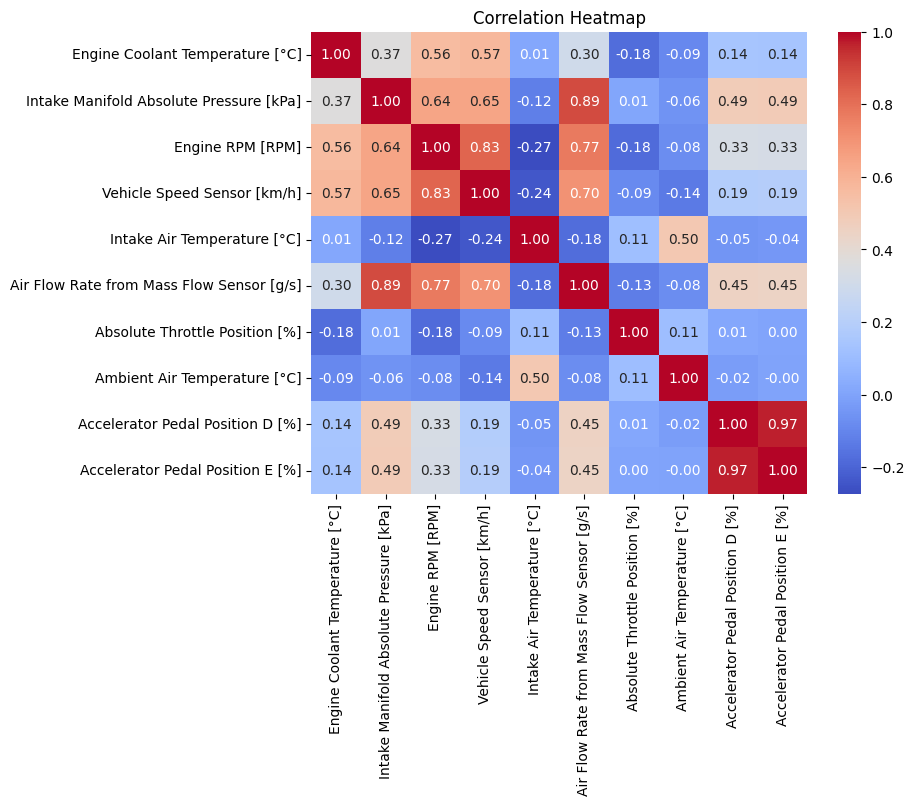

In [31]:
sub_df = df.drop(columns=['date', 'Time', 'model', 'brand', 'source', 'destination', 'condition'])
corr_matrix = sub_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [32]:
df.columns

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'Intake Air Temperature [°C]',
       'Air Flow Rate from Mass Flow Sensor [g/s]',
       'Absolute Throttle Position [%]', 'Ambient Air Temperature [°C]',
       'Accelerator Pedal Position D [%]', 'Accelerator Pedal Position E [%]',
       'date', 'brand', 'model', 'source', 'destination', 'condition'],
      dtype='object')

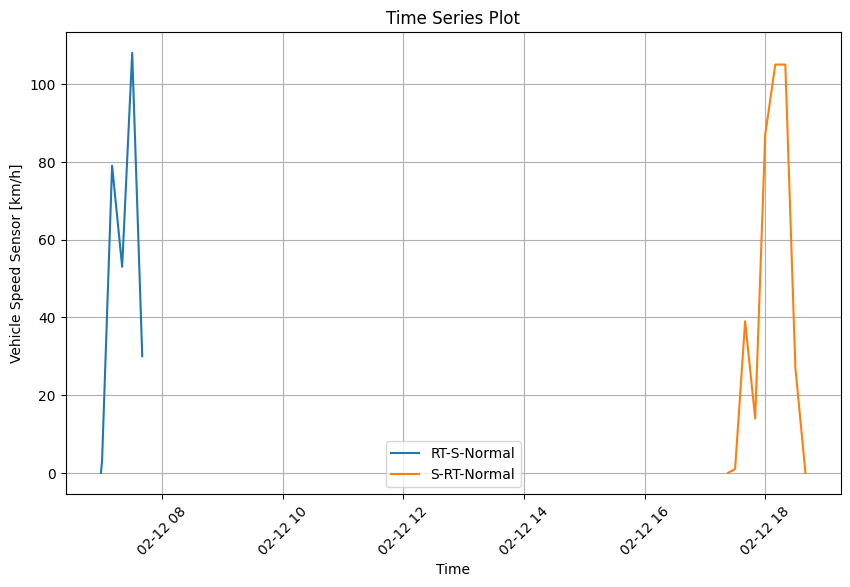

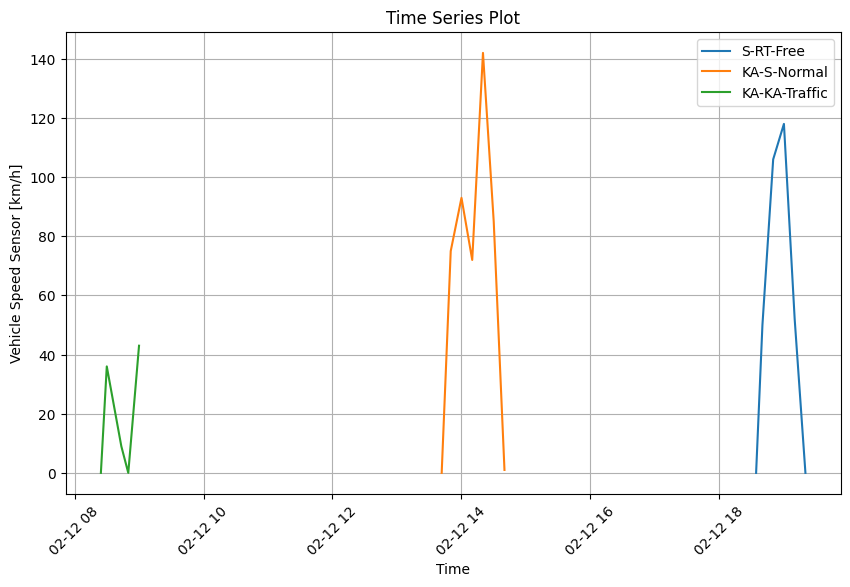

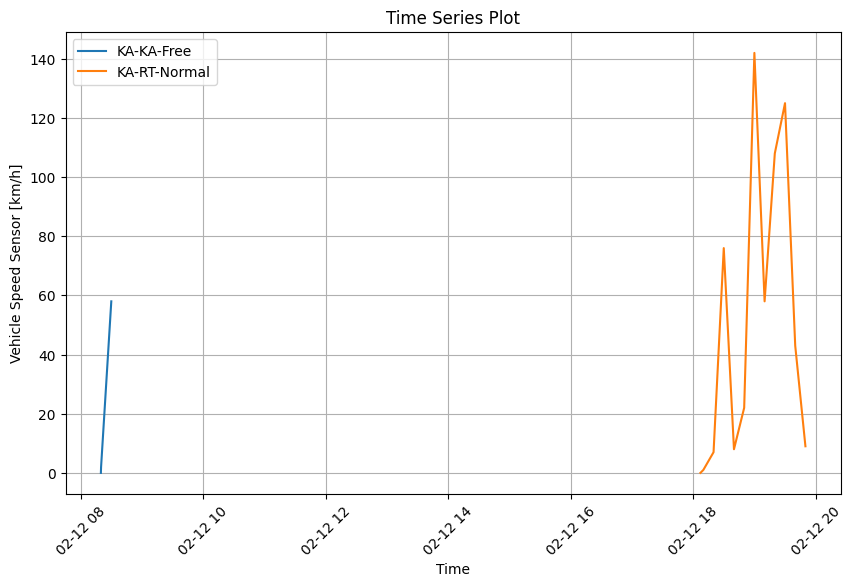

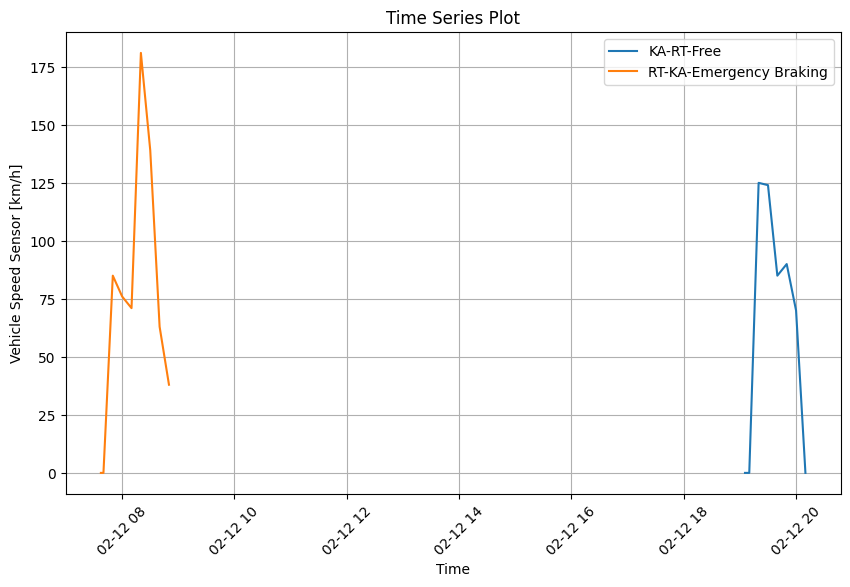

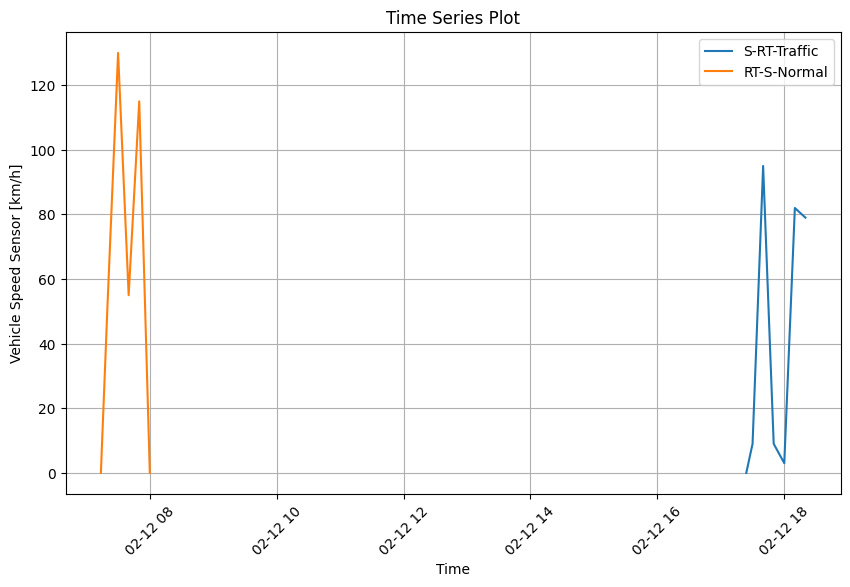

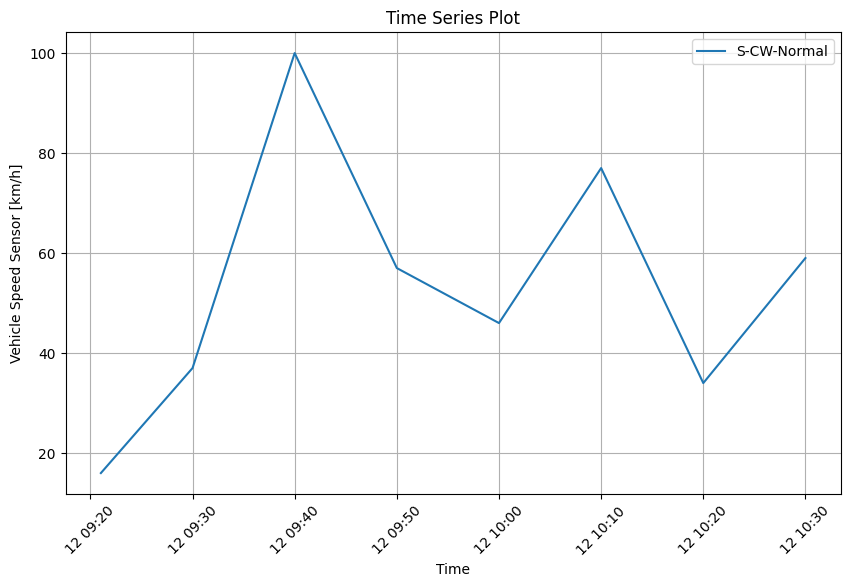

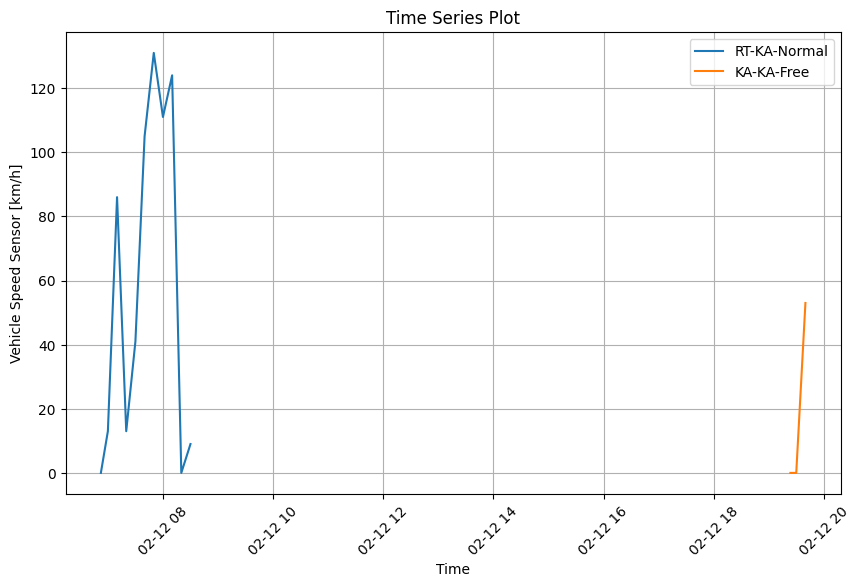

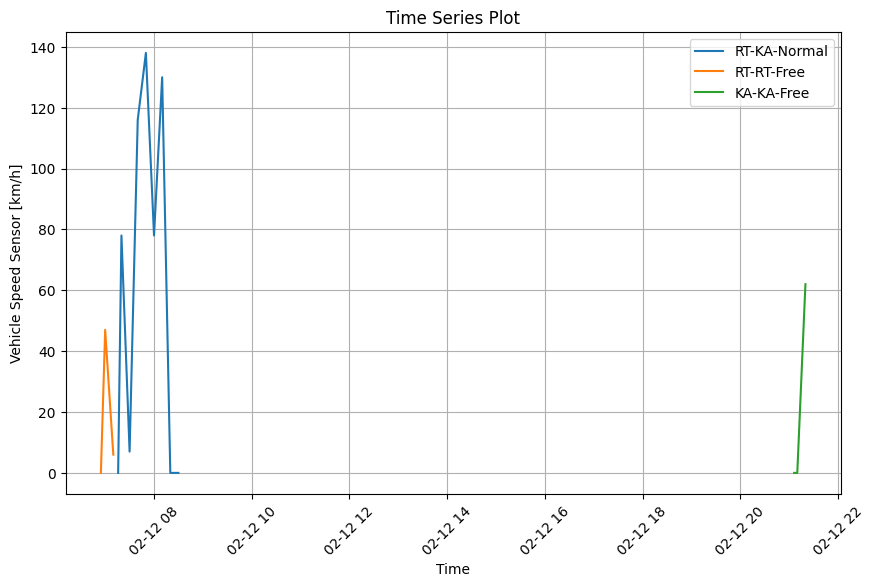

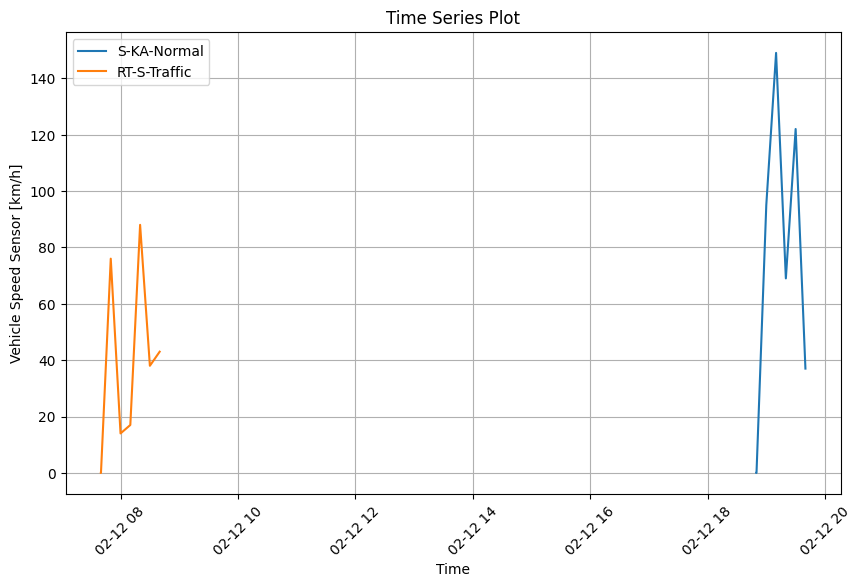

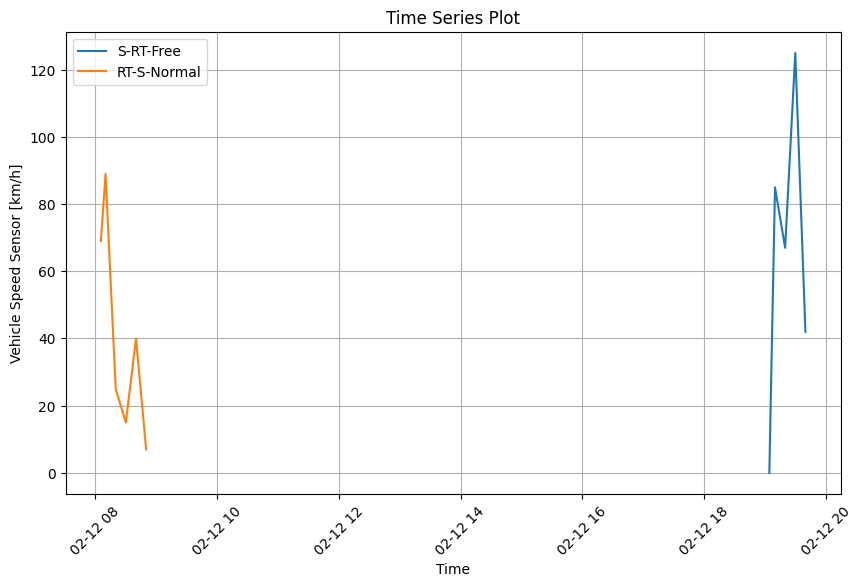

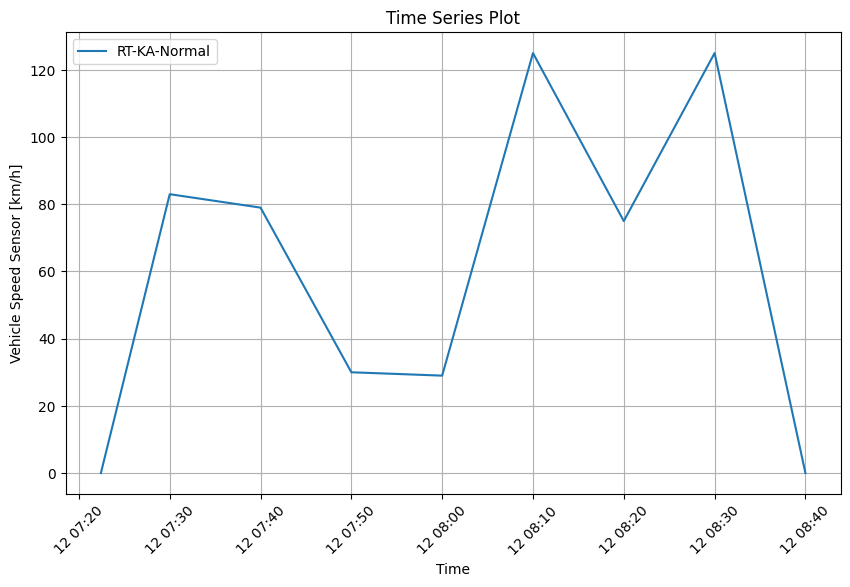

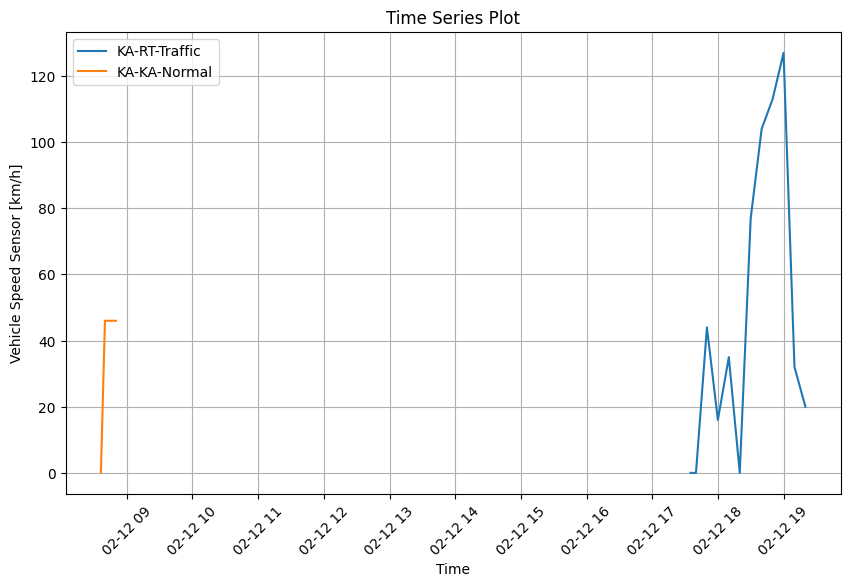

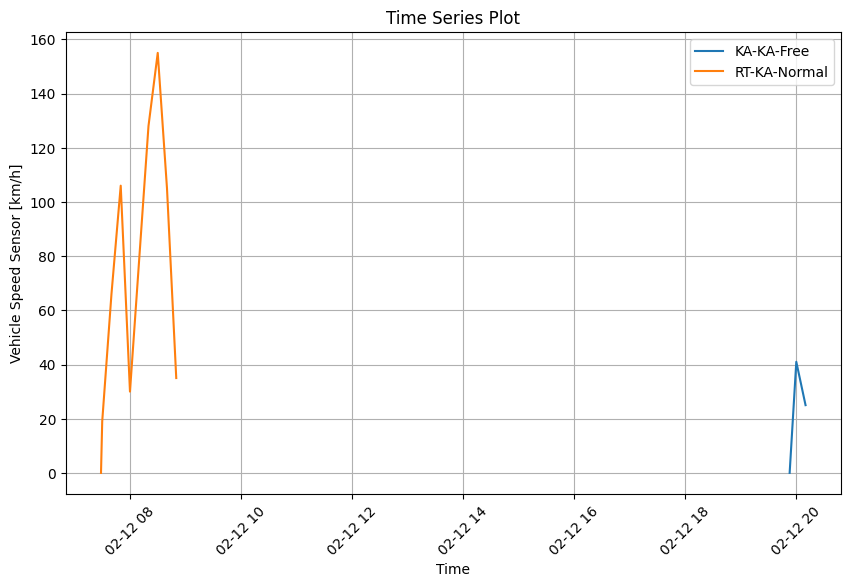

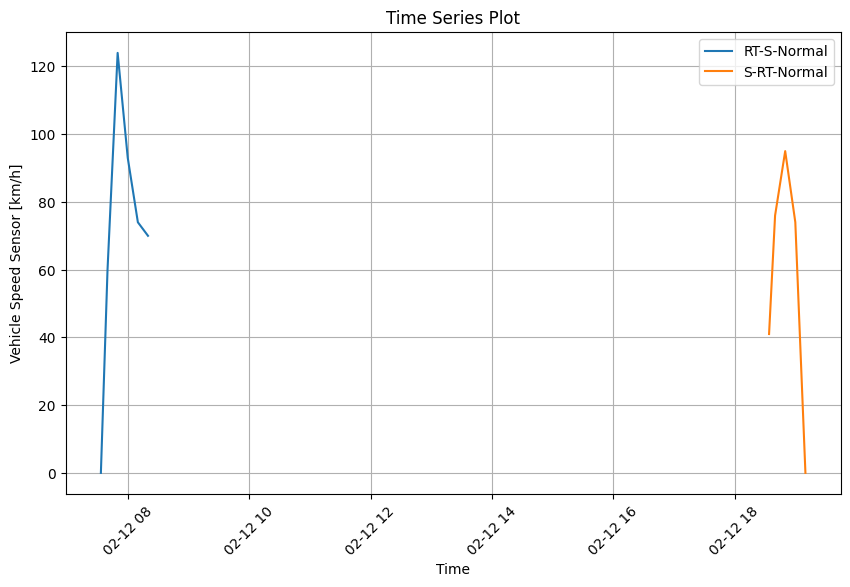

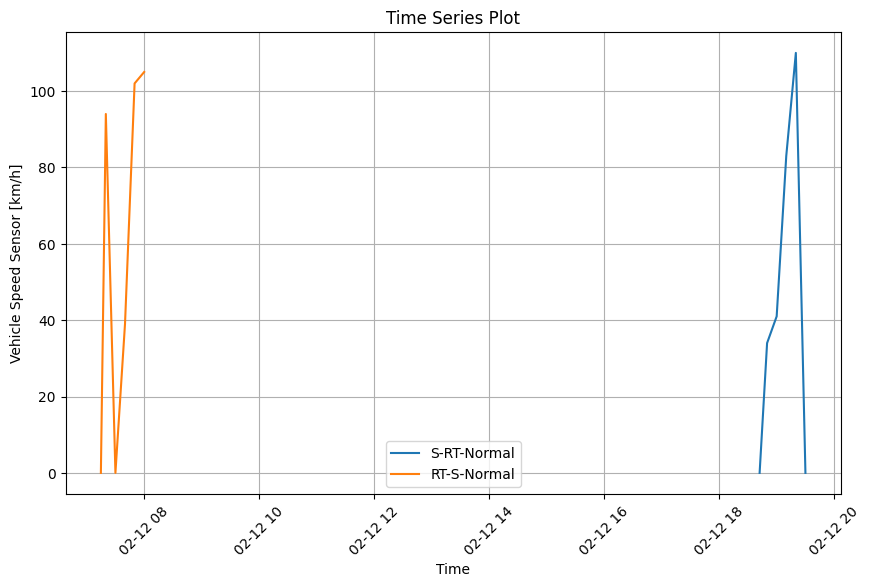

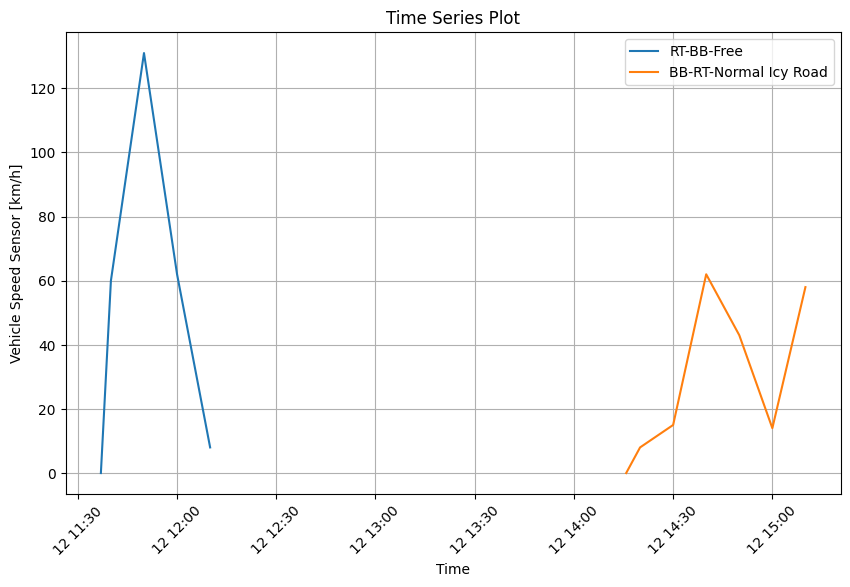

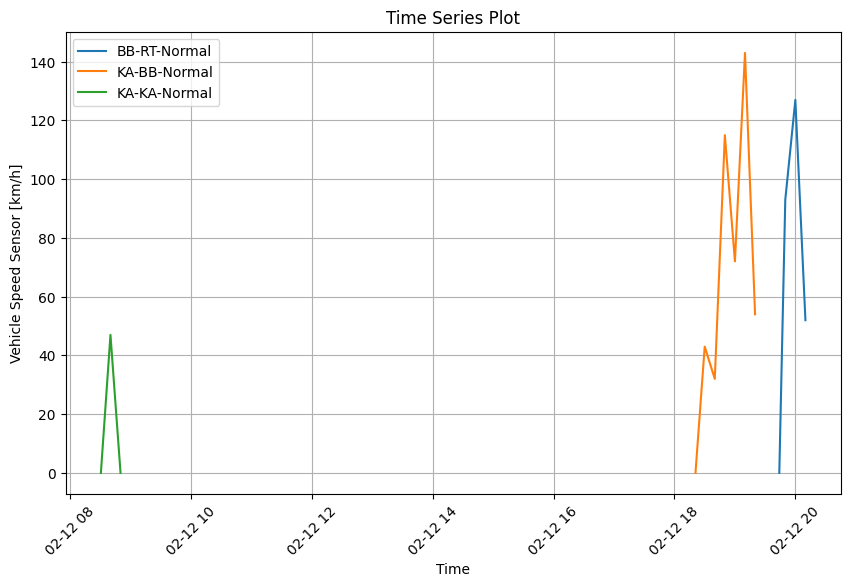

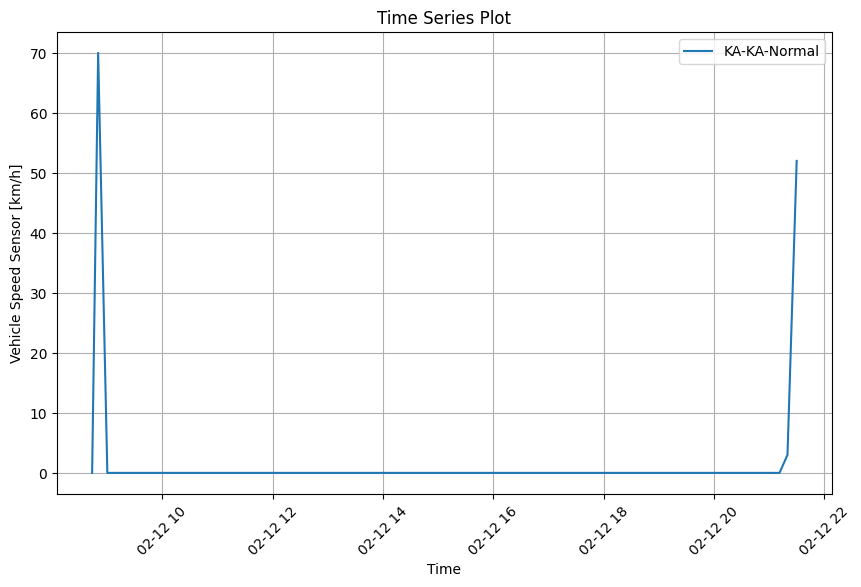

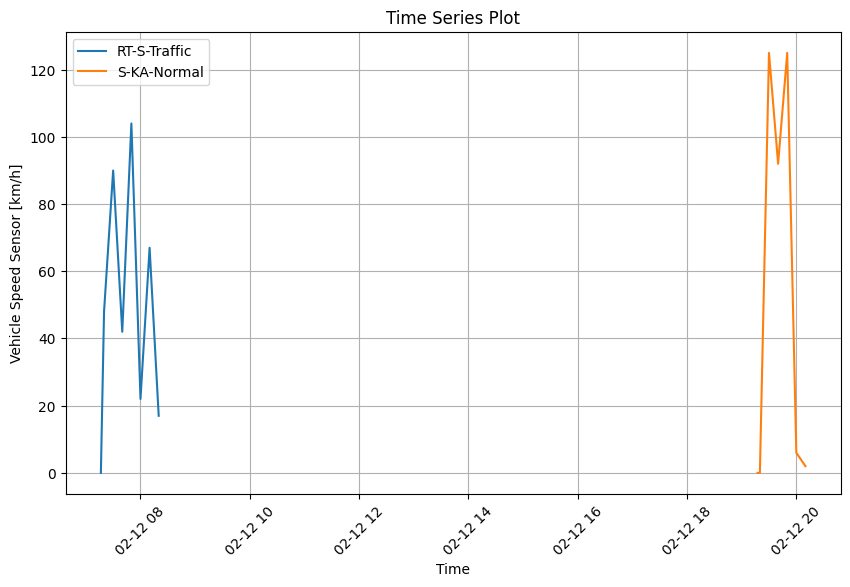

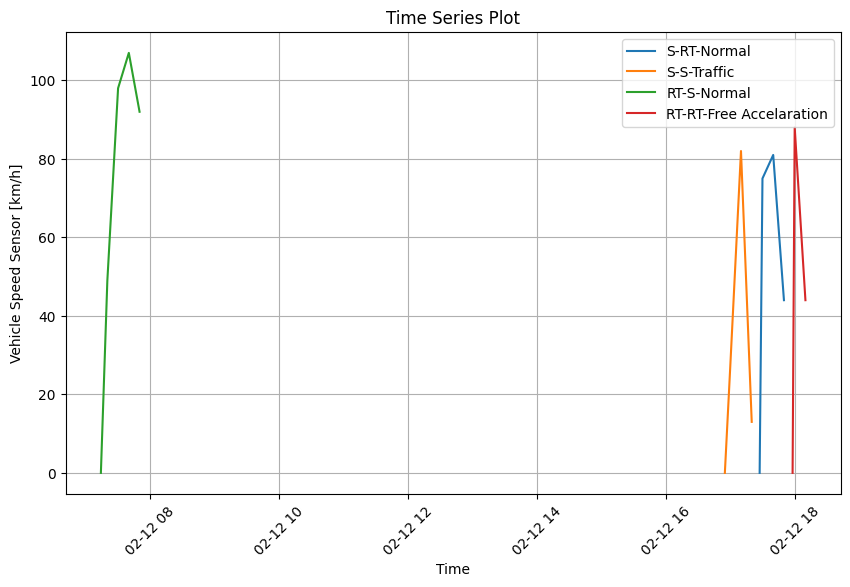

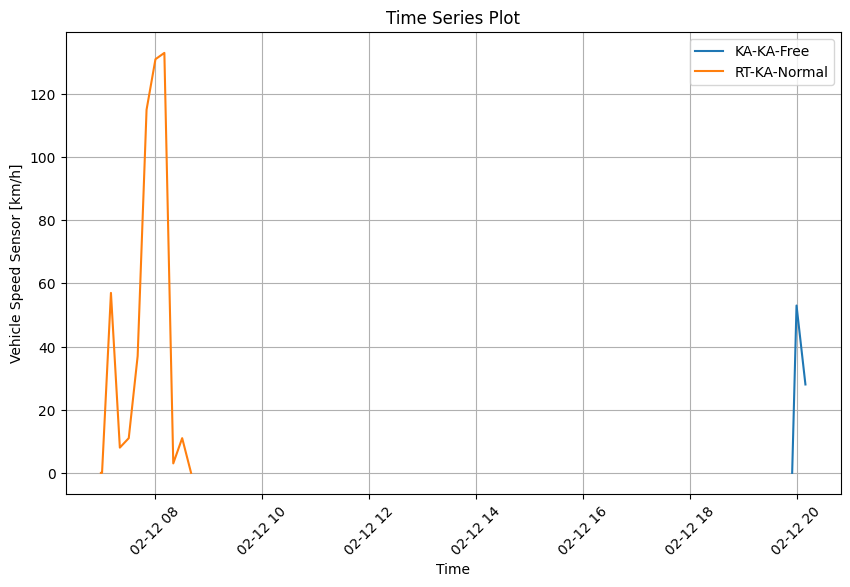

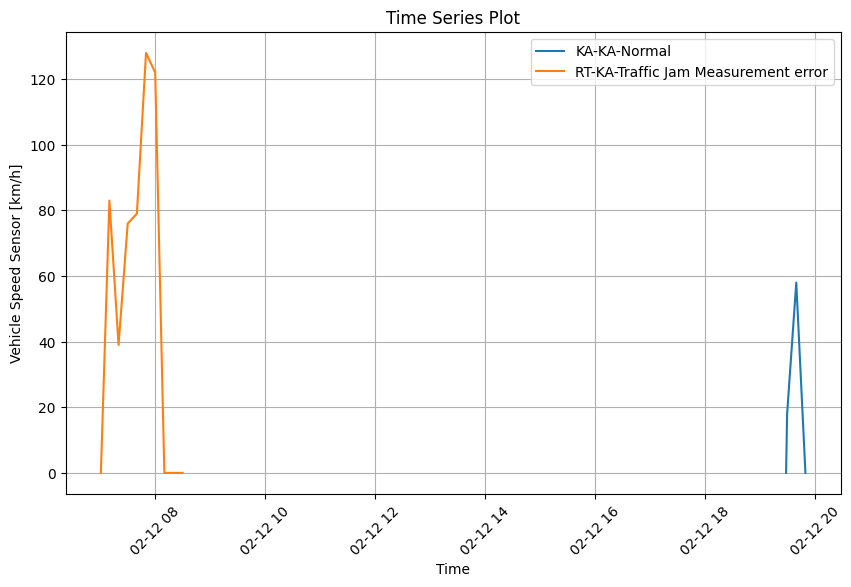

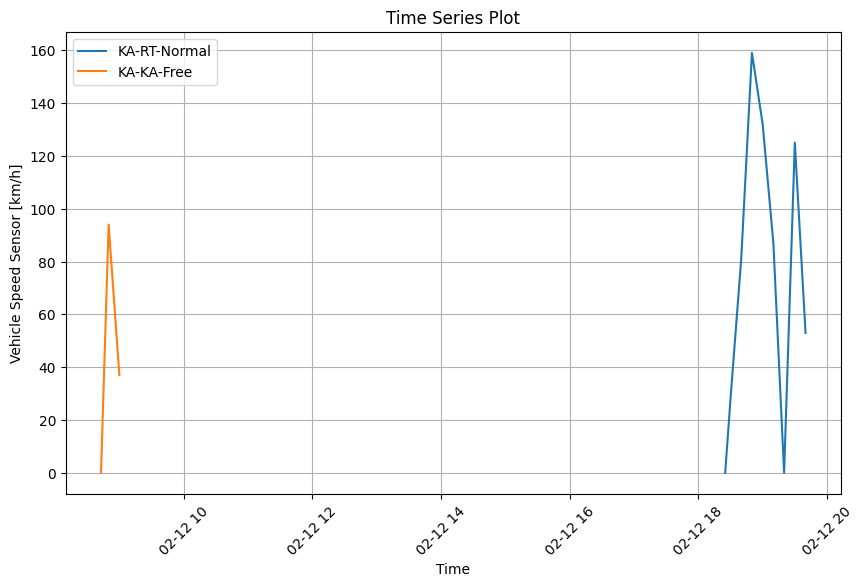

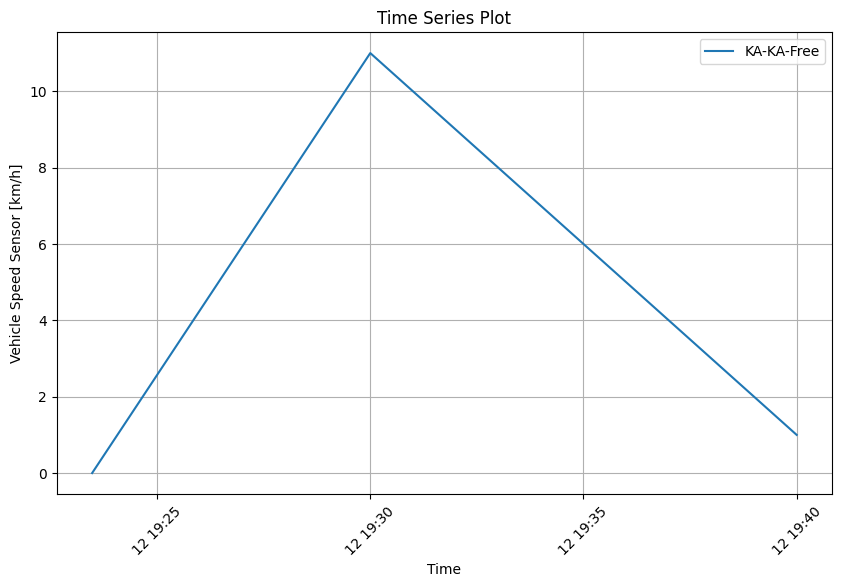

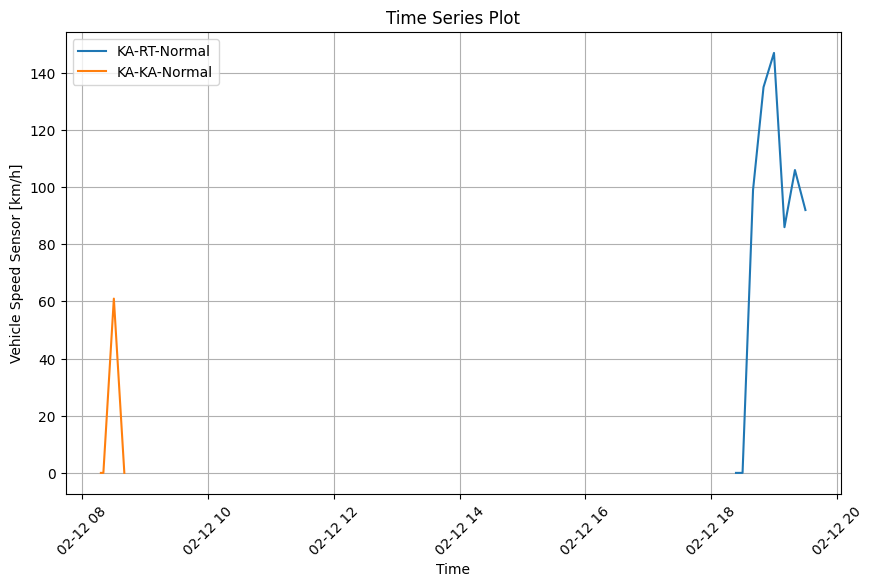

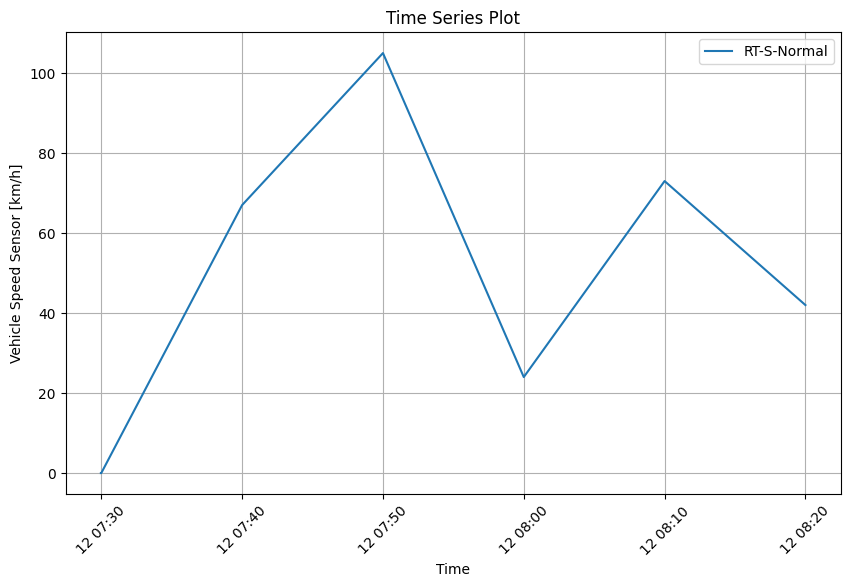

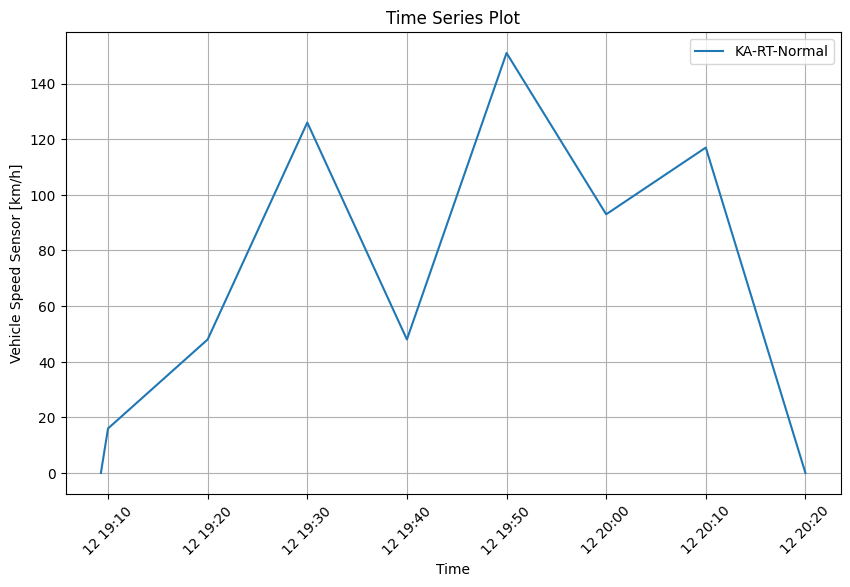

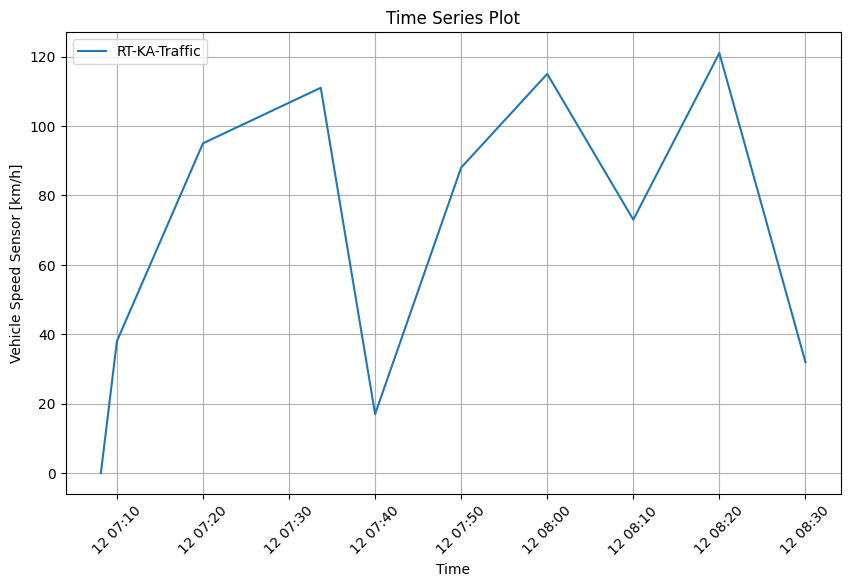

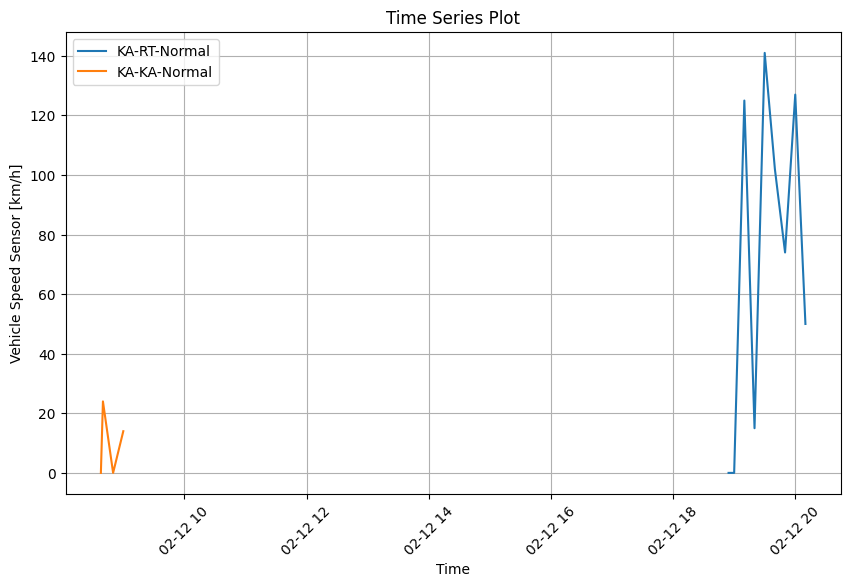

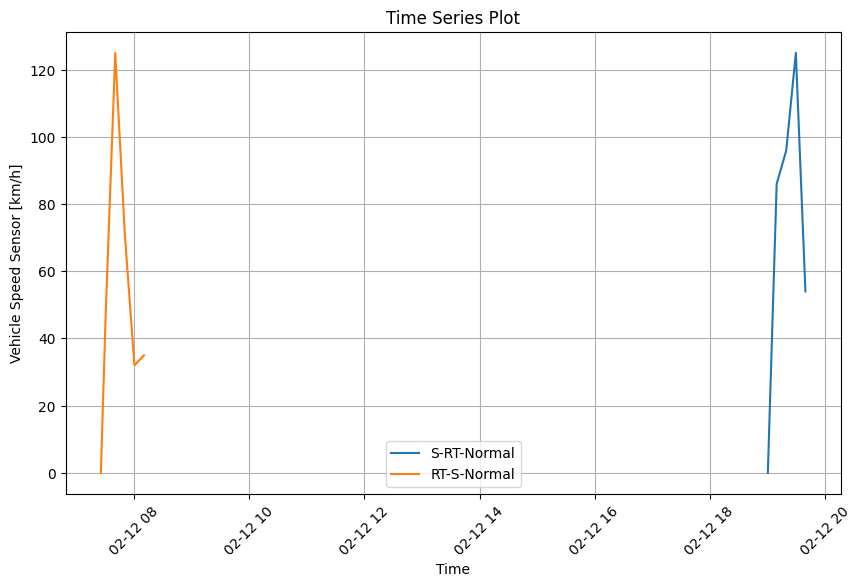

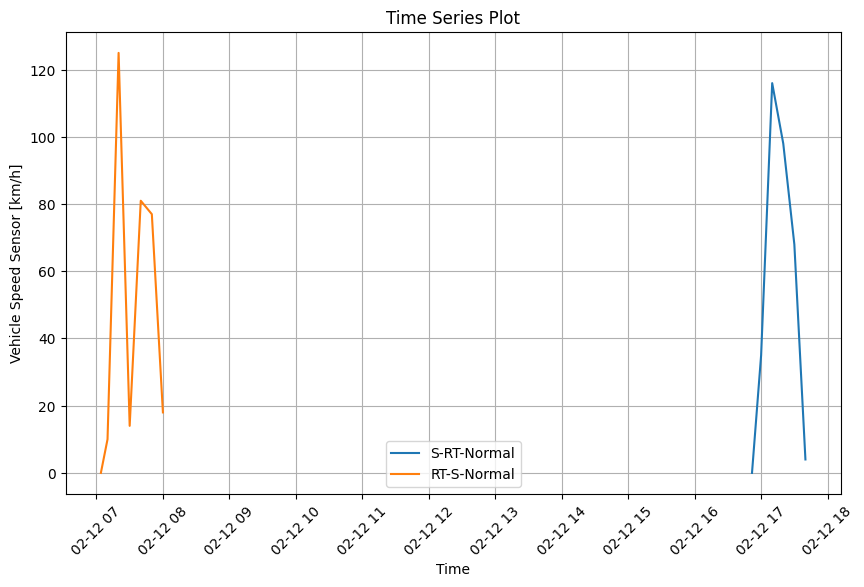

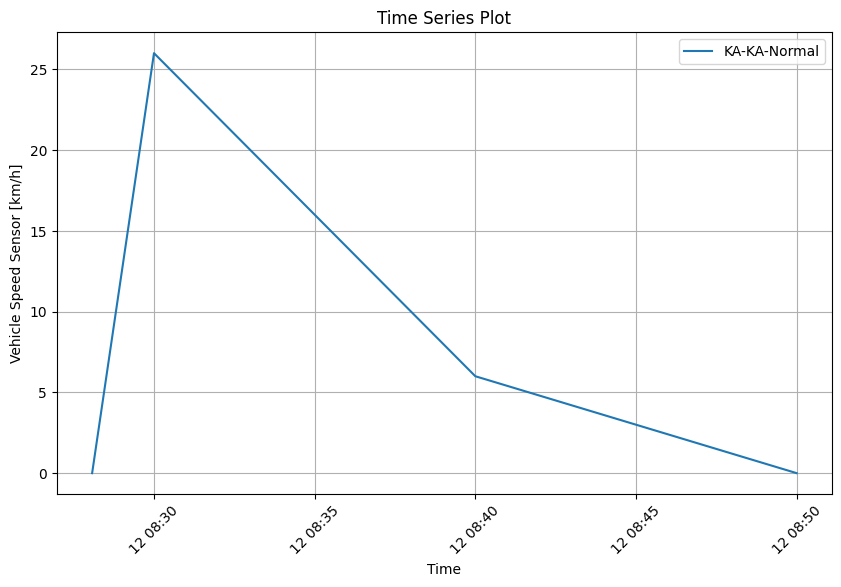

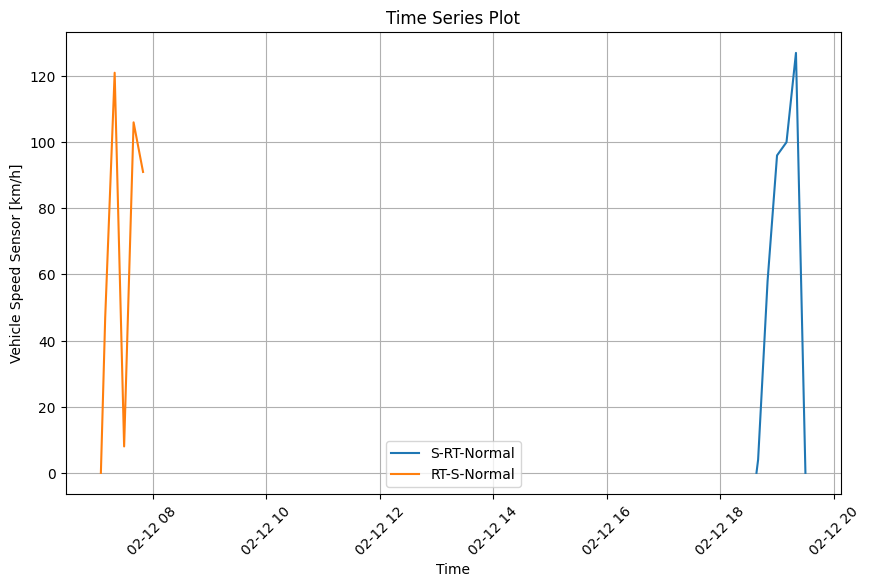

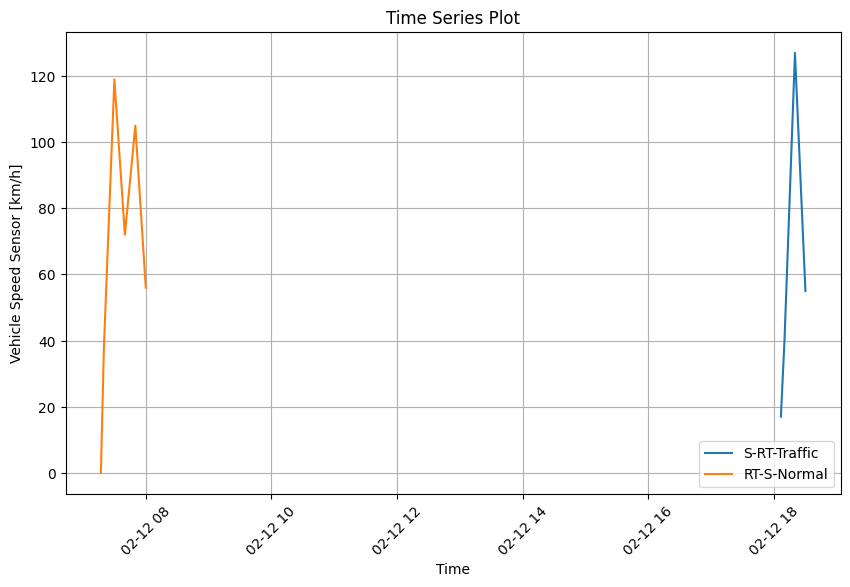

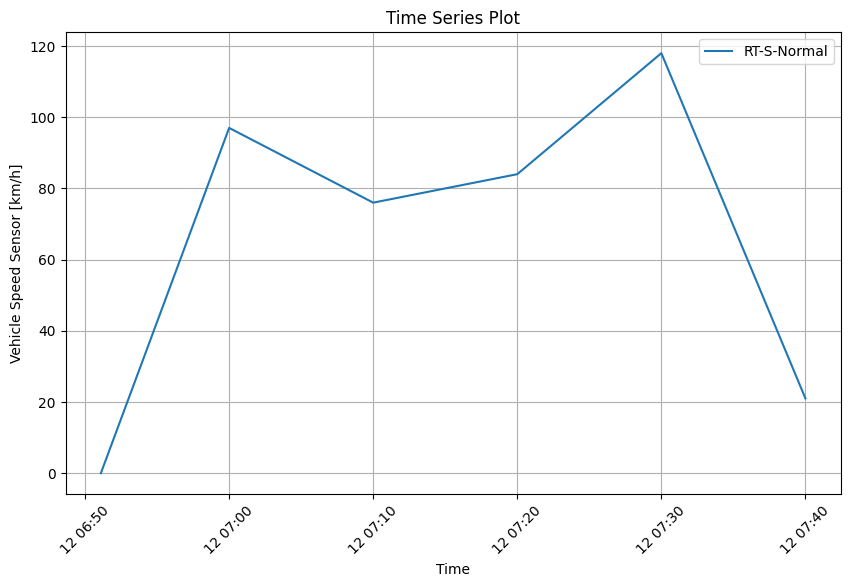

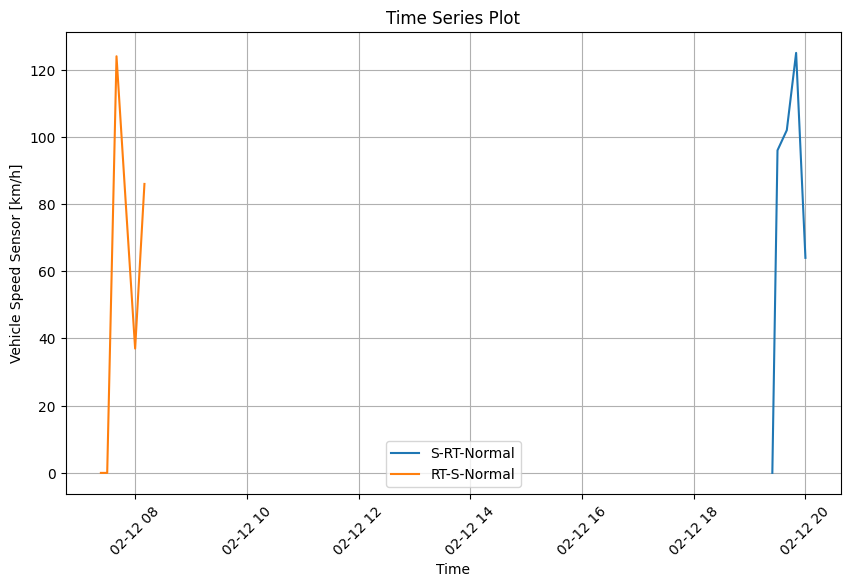

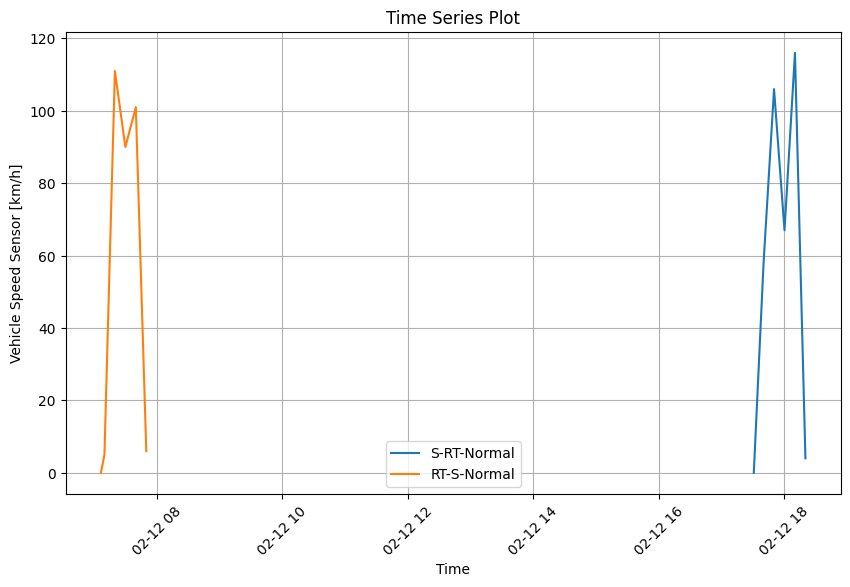

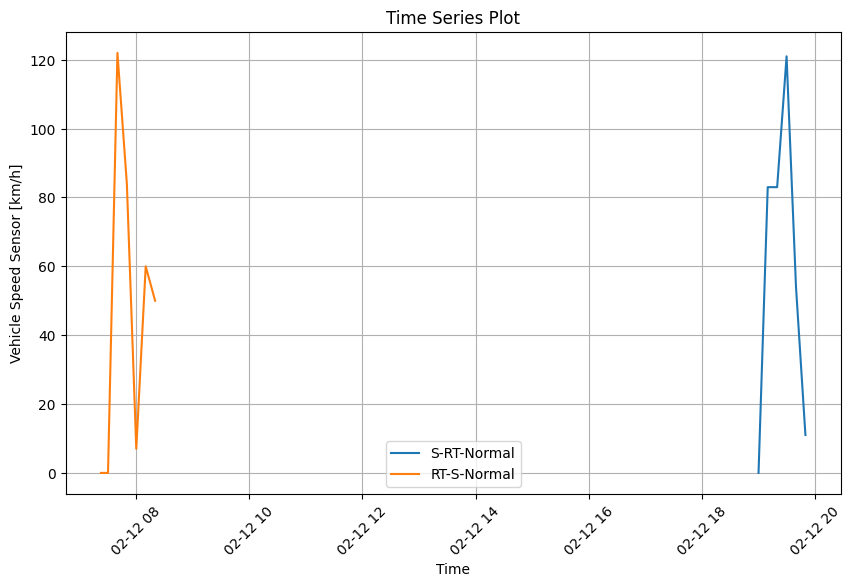

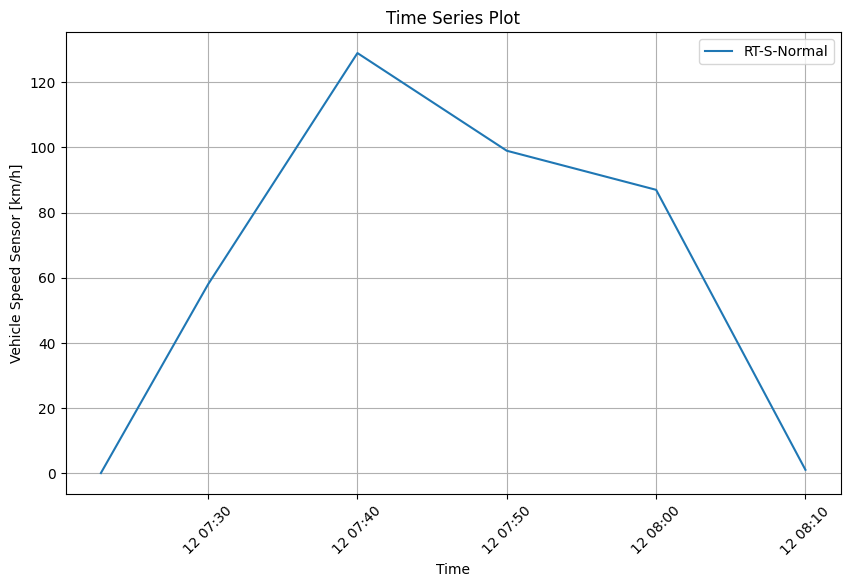

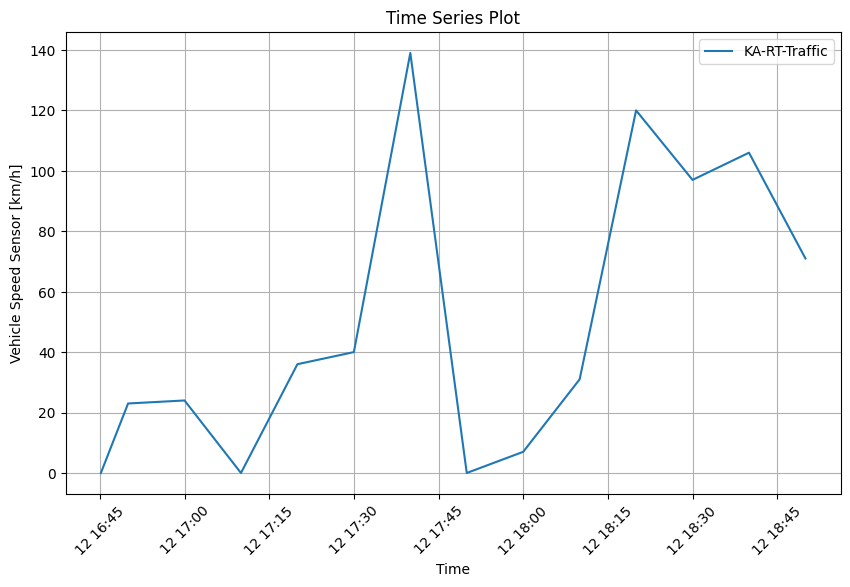

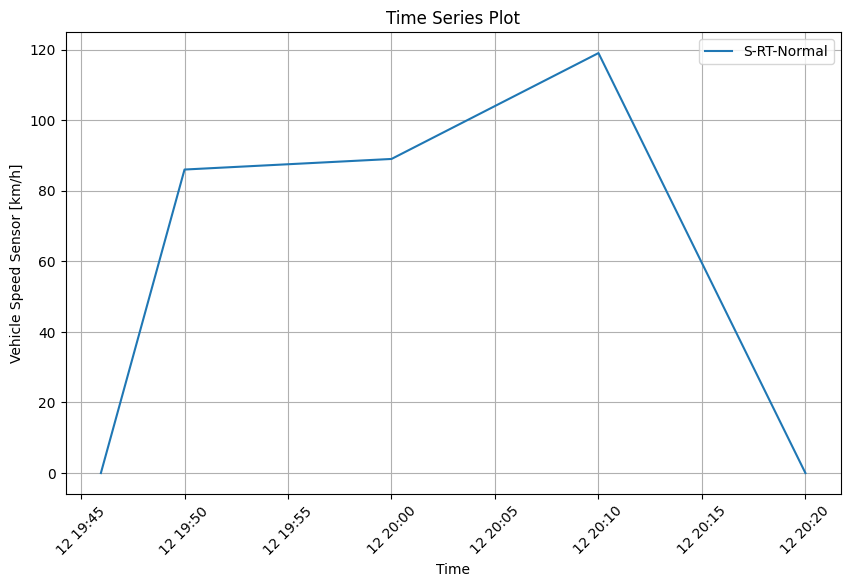

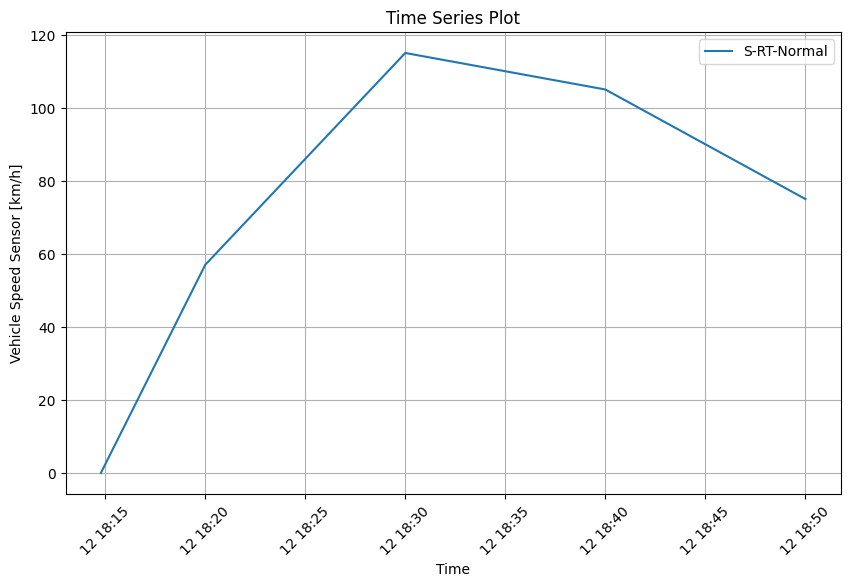

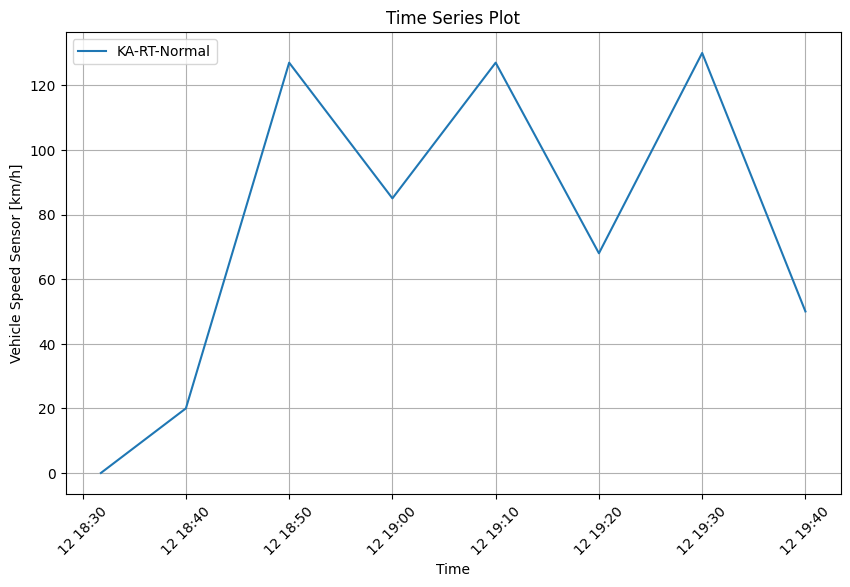

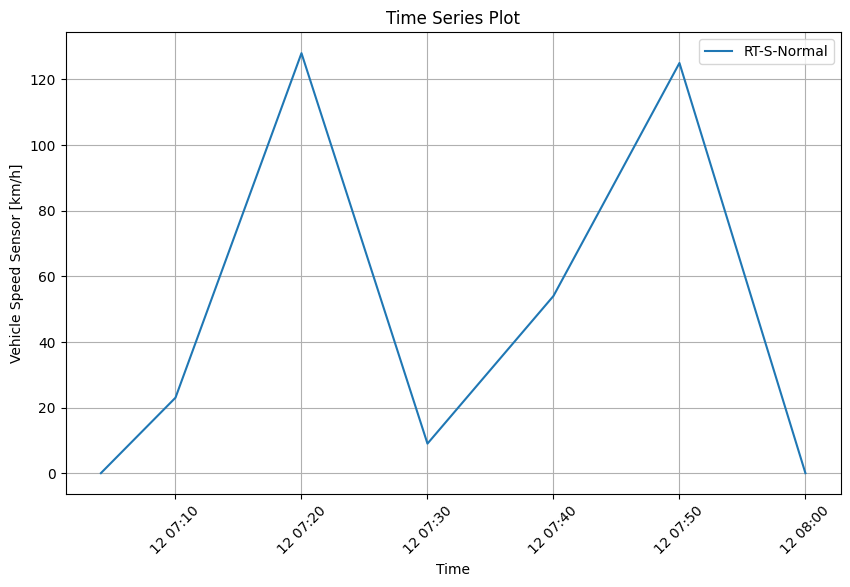

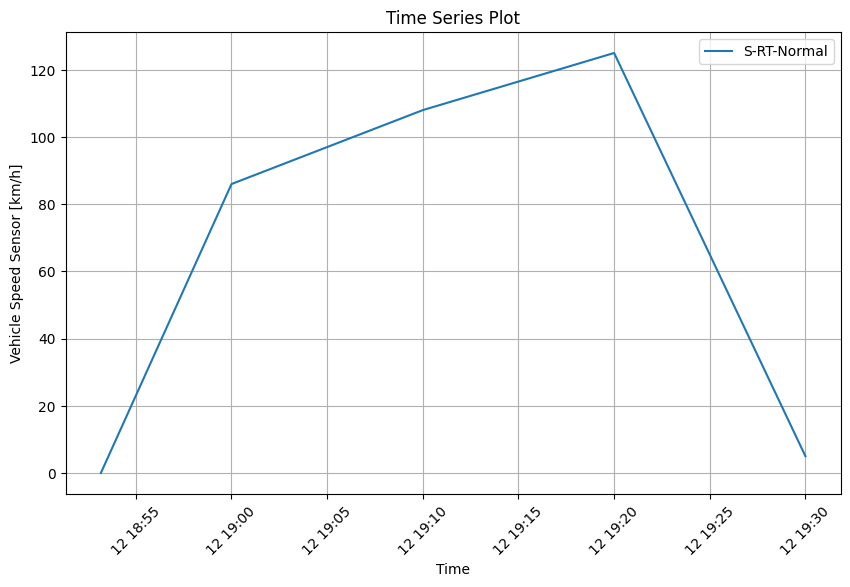

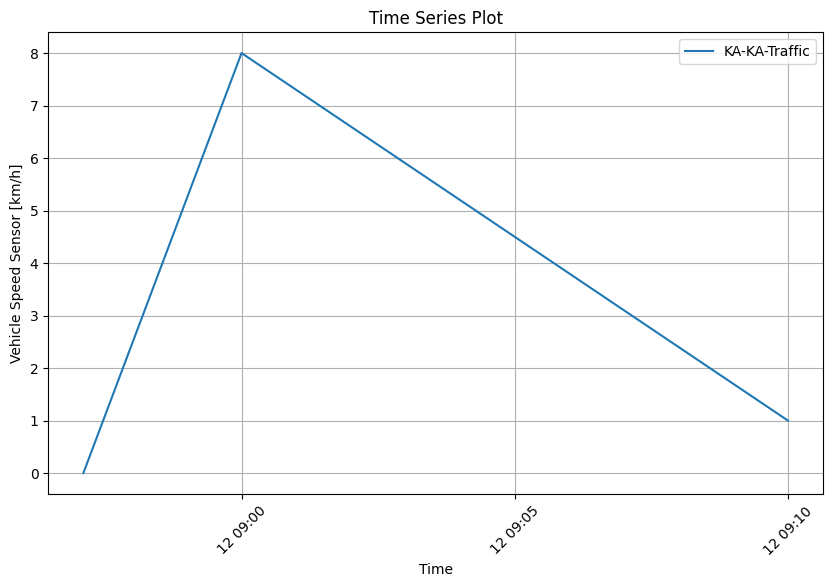

In [33]:
unique_days = df['date'].unique()
for day in unique_days:
    plt.figure(figsize=(10, 6))
    plt.title('Time Series Plot')
    plt.xlabel('Time')
    plt.ylabel('Vehicle Speed Sensor [km/h]')

    sub_df:pd.DataFrame = df[df['date'] == day]
    unique_pairs = sub_df[['source', 'destination', 'condition']].drop_duplicates()
    for index, row in unique_pairs.iterrows():
        sub_sub_df:pd.DataFrame = sub_df[(sub_df["source"] == row["source"]) & (sub_df["destination"] == row["destination"]) & (sub_df["condition"] == row["condition"])]
        plt.plot(sub_sub_df['Time'], sub_sub_df['Vehicle Speed Sensor [km/h]'], label=f"{row['source']}-{row['destination']}-{row['condition']}")
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()  # Add legend
    plt.show()
        
        

#### Factorize Categorical Columns
First we need to factorize categorical columns so that they can be used as fields to train our forcasting model. We would be detecting all the categorical columns and replacing them with numeric values


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2024-02-12 06:50:00 to 2024-02-12 09:10:00
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Time                                       505 non-null    datetime64[ns]
 1   Engine Coolant Temperature [°C]            258 non-null    float64       
 2   Intake Manifold Absolute Pressure [kPa]    505 non-null    float64       
 3   Engine RPM [RPM]                           505 non-null    float64       
 4   Vehicle Speed Sensor [km/h]                505 non-null    float64       
 5   Intake Air Temperature [°C]                258 non-null    float64       
 6   Air Flow Rate from Mass Flow Sensor [g/s]  505 non-null    float64       
 7   Absolute Throttle Position [%]             505 non-null    float64       
 8   Ambient Air Temperature [°C]               258 non-null    floa

##### First lets convert the date field to pandas datetime format

In [35]:
df['date'] = pd.to_datetime(df['date'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2024-02-12 06:50:00 to 2024-02-12 09:10:00
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Time                                       505 non-null    datetime64[ns]
 1   Engine Coolant Temperature [°C]            258 non-null    float64       
 2   Intake Manifold Absolute Pressure [kPa]    505 non-null    float64       
 3   Engine RPM [RPM]                           505 non-null    float64       
 4   Vehicle Speed Sensor [km/h]                505 non-null    float64       
 5   Intake Air Temperature [°C]                258 non-null    float64       
 6   Air Flow Rate from Mass Flow Sensor [g/s]  505 non-null    float64       
 7   Absolute Throttle Position [%]             505 non-null    float64       
 8   Ambient Air Temperature [°C]               258 non-null    floa

In [37]:
# get all the unique values of brand, model, source, destination and condition
brands = list(df["brand"].unique())
models  = list(df["model"].unique())
locations = list(set(list(df['source'].unique()) + list(df['destination'])))
conditions = list(df["condition"].unique())

In [38]:
brands, models, locations, conditions

(['Seat'],
 ['Leon'],
 ['S', 'BB', 'CW', 'RT', 'KA'],
 ['Normal',
  'Free',
  'Traffic',
  'Emergency Braking',
  'Normal Icy Road',
  'Free Accelaration',
  'Traffic Jam Measurement error'])

In [39]:
analytics_df = df.copy()


In [40]:
# transform brand
def transform_brand(brand):
    return brands.index(brand)

analytics_df['brand'] = df['brand'].apply(transform_brand)


In [41]:
def transform_model(model):
    return models.index(model)

analytics_df["model"] = df["model"].apply(transform_model)

In [42]:
def transform_location(location):
    return locations.index(location)

analytics_df["source"] = df["source"].apply(transform_location)
analytics_df["destination"] = df["destination"].apply(transform_location)

In [43]:
def transform_condition(condition):
    return conditions.index(condition)

analytics_df["condition"] = df["condition"].apply(transform_condition)

In [44]:
df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition
RoundedTime,,,,,,,,,,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,0.0,0.86,89.0,0.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,5.0,18.72,83.5,-2.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,-4.0,22.11,83.5,-8.0,38.8,39.2,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,-5.0,11.61,83.5,-8.0,20.4,16.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,-3.0,16.38,83.5,-9.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal


In [45]:
analytics_df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition
RoundedTime,,,,,,,,,,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,0.0,0.86,89.0,0.0,14.1,14.5,2018-03-01,0,0,3,0,0
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,5.0,18.72,83.5,-2.0,14.1,14.5,2018-03-01,0,0,3,0,0
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,-4.0,22.11,83.5,-8.0,38.8,39.2,2018-03-01,0,0,3,0,0
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,-5.0,11.61,83.5,-8.0,20.4,16.5,2018-03-01,0,0,3,0,0
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,-3.0,16.38,83.5,-9.0,14.1,14.5,2018-03-01,0,0,3,0,0


#### Using Arima Model
ARIMA (AutoRegressive Integrated Moving Average) is a widely used time series forecasting model in machine learning. It's particularly effective for analyzing and forecasting time series data that exhibits non-stationary behavior, meaning the statistical properties such as mean and variance change over time. 

We would be using ARIMA as our first forcasting model in this process

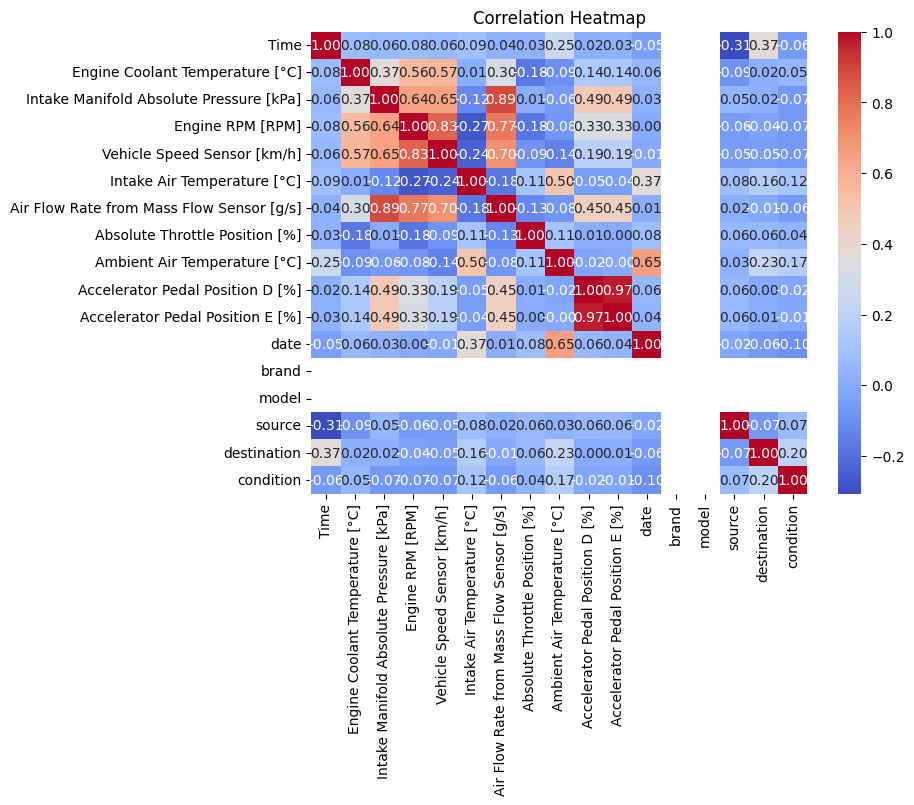

In [46]:
corr_matrix = analytics_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [47]:
analytics_df.columns

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'Intake Air Temperature [°C]',
       'Air Flow Rate from Mass Flow Sensor [g/s]',
       'Absolute Throttle Position [%]', 'Ambient Air Temperature [°C]',
       'Accelerator Pedal Position D [%]', 'Accelerator Pedal Position E [%]',
       'date', 'brand', 'model', 'source', 'destination', 'condition'],
      dtype='object')

In [48]:
# we would remove all the columns that do not have high correlation with our target whic is vehicle speed sensor
columns_to_keep = ['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Vehicle Speed Sensor [km/h]', 'Engine RPM [RPM]', 'source', 'destination', 'condition']

In [49]:
# Identify columns to drop
columns_to_drop = set(analytics_df.columns) - set(columns_to_keep)

# Drop columns not in the specified set
analytics_df:pd.DataFrame = analytics_df.drop(columns=columns_to_drop)

In [50]:
analytics_df.columns

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'source', 'destination', 'condition'],
      dtype='object')

In [53]:
import statsmodels.api as sm

In [55]:
analytics_df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],source,destination,condition
RoundedTime,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,3,0,0
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,3,0,0
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,3,0,0
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,3,0,0
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,3,0,0


In [60]:
analytics_df.shape[0]

505

In [61]:
analytics_df = analytics_df.dropna(how='any')

In [62]:
analytics_df.shape[0]

258

In [64]:
train_size = int(analytics_df.shape[0] * 0.8)
train_size

206

In [65]:
train_data = analytics_df[:train_size]
test_data = analytics_df[train_size:]

In [66]:
model = sm.tsa.ARIMA(train_data['Vehicle Speed Sensor [km/h]'], order=(1, 1, 1), exog=train_data[['Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]', 'source',
       'destination', 'condition']])
fit_model = model.fit()

/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-pa

In [67]:
# Forecast
forecast = fit_model.forecast(steps=len(test_data), exog=test_data[['Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]', 'source',
       'destination', 'condition']])

/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [70]:
type(forecast)

pandas.core.series.Series

##### Visually compare forecast against actual predicted data

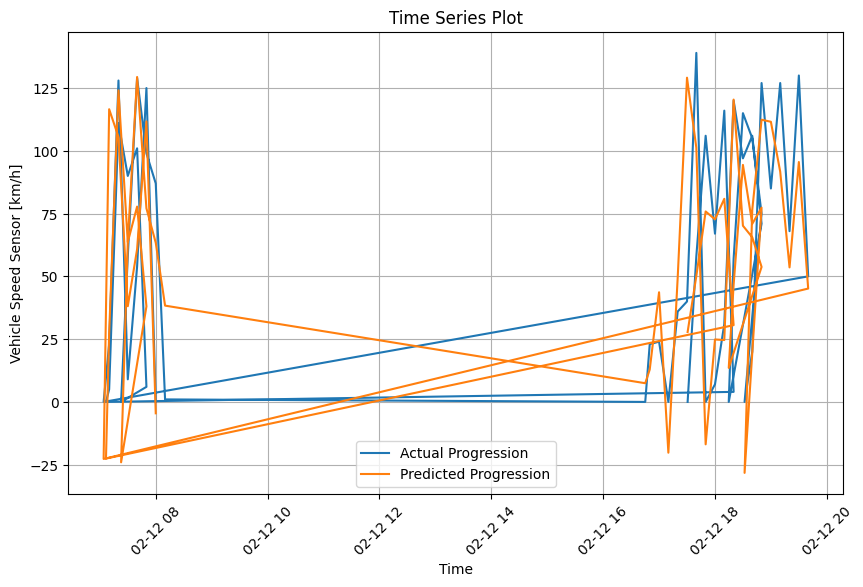

In [71]:
plt.figure(figsize=(10, 6))
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Vehicle Speed Sensor [km/h]')
plt.plot(test_data['Time'], test_data['Vehicle Speed Sensor [km/h]'], label=f"Actual Progression")
plt.plot(test_data['Time'], forecast, label=f"Predicted Progression")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Add legend
plt.show()

### Predict Categorical Data
In this section we would be training a category prediction model to detect the condition of the vehicle given the hour, minute, source, destination and vehicle speed.

In [72]:
analytics_df['hour'] = analytics_df['Time'].dt.hour
analytics_df['minute'] = analytics_df['Time'].dt.minute

In [73]:
analytics_df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],source,destination,condition,hour,minute
RoundedTime,,,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,3,0,0,6,58
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,3,0,0,7,0
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,3,0,0,7,10
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,3,0,0,7,20
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,3,0,0,7,30


In [74]:
analytics_df.columns

Index(['Time', 'Engine Coolant Temperature [°C]',
       'Intake Manifold Absolute Pressure [kPa]', 'Engine RPM [RPM]',
       'Vehicle Speed Sensor [km/h]', 'source', 'destination', 'condition',
       'hour', 'minute'],
      dtype='object')

In [75]:
reserved_columns = ['Vehicle Speed Sensor [km/h]', 'source', 'destination', 'condition',
       'hour', 'minute']
columns_to_drop = set(analytics_df.columns) - set(reserved_columns)


In [76]:
columns_to_drop

{'Engine Coolant Temperature [°C]',
 'Engine RPM [RPM]',
 'Intake Manifold Absolute Pressure [kPa]',
 'Time'}

In [78]:
categoryical_analysis_df = analytics_df.drop(columns=list(columns_to_drop))

In [79]:
categoryical_analysis_df.head()

,Vehicle Speed Sensor [km/h],source,destination,condition,hour,minute
RoundedTime,,,,,,
2024-02-12 06:50:00,0.0,3,0,0,6,58
2024-02-12 07:00:00,3.0,3,0,0,7,0
2024-02-12 07:10:00,79.0,3,0,0,7,10
2024-02-12 07:20:00,53.0,3,0,0,7,20
2024-02-12 07:30:00,108.0,3,0,0,7,30


In [82]:
X = categoryical_analysis_df.drop(columns=['condition'])
y = categoryical_analysis_df['condition']

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [84]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# train the random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [86]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.8076923076923077


We were able to acheive 80% accuracy on our condition prediction model 🎉🎉🎉🎉

### Build the query engine 
Once the dataset has been loaded into a pandas dataframe, we can now use llama index to build a query engine on our dataframe

In [88]:
from llama_index.llms.openai import OpenAI
from llama_index.service_context import ServiceContext
from llama_index.query_engine.pandas import PandasQueryEngine

In [89]:
llm = OpenAI(model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [90]:
df.head()

,Time,Engine Coolant Temperature [°C],Intake Manifold Absolute Pressure [kPa],Engine RPM [RPM],Vehicle Speed Sensor [km/h],Intake Air Temperature [°C],Air Flow Rate from Mass Flow Sensor [g/s],Absolute Throttle Position [%],Ambient Air Temperature [°C],Accelerator Pedal Position D [%],Accelerator Pedal Position E [%],date,brand,model,source,destination,condition
RoundedTime,,,,,,,,,,,,,,,,,
2024-02-12 06:50:00,2024-02-12 06:58:50.068,8.0,95.0,0.0,0.0,0.0,0.86,89.0,0.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:00:00,2024-02-12 07:00:00.085,11.0,101.0,1045.0,3.0,5.0,18.72,83.5,-2.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:10:00,2024-02-12 07:10:00.004,66.0,130.0,1607.0,79.0,-4.0,22.11,83.5,-8.0,38.8,39.2,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:20:00,2024-02-12 07:20:00.029,89.0,104.0,1360.0,53.0,-5.0,11.61,83.5,-8.0,20.4,16.5,2018-03-01,Seat,Leon,RT,S,Normal
2024-02-12 07:30:00,2024-02-12 07:30:00.086,90.0,108.0,1818.0,108.0,-3.0,16.38,83.5,-9.0,14.1,14.5,2018-03-01,Seat,Leon,RT,S,Normal


In [91]:
service_context = ServiceContext.from_defaults(llm=llm)

In [92]:
query_engine_with_sythesis =  PandasQueryEngine(df=df, service_context=service_context, verbose=True, synthesize_response=True)
query_engine =  PandasQueryEngine(df=df, service_context=service_context, verbose=True, synthesize_response=False)

In [93]:
response = query_engine_with_sythesis.query("what was the maximum speed on the 26th of march 2018?")

> Pandas Instructions:
```
df.loc[df['date'] == '2018-03-26', 'Vehicle Speed Sensor [km/h]'].max()
```
> Pandas Output: 127.0


In [94]:
from pprint import pprint
pprint(response.response)

'On the 26th of March, 2018, the maximum speed recorded was 127.0 km/h.'


In [96]:
response = query_engine_with_sythesis.query("based on the columns available in the dataset what kind of machine learning models can i train and what visualizations can i perform?")

> Pandas Instructions:
```
# Machine learning models that can be trained:
models = {
    "Regression": ["Engine RPM [RPM]", "Vehicle Speed Sensor [km/h]", "Air Flow Rate from Mass Flow Sensor [g/s]"],
    "Classification": ["condition"],
    "Time Series Forecasting": ["Engine Coolant Temperature [°C]", "Intake Manifold Absolute Pressure [kPa]", "Intake Air Temperature [°C]", "Ambient Air Temperature [°C]"],
    "Clustering": ["date", "brand", "model", "source", "destination"]
}

# Visualizations that can be performed:
visualizations = {
    "Scatter Plot": ["Engine RPM [RPM]" against "Vehicle Speed Sensor [km/h]"],
    "Line Plot": ["Engine Coolant Temperature [°C]" over time],
    "Histogram": ["Air Flow Rate from Mass Flow Sensor [g/s]"],
    "Box Plot": ["Intake Manifold Absolute Pressure [kPa]" by "condition"],
    "Heatmap": ["Engine RPM [RPM]", "Vehicle Speed Sensor [km/h]", "Air Flow Rate from Mass Flow Sensor [g/s]", "condition"],
    "Pairplot": ["Engine Coolant Temperature [

Traceback (most recent call last):
  File "/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/llama_index/query_engine/pandas/output_parser.py", line 40, in default_output_processor
    tree = ast.parse(output)
           ^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<unknown>", line 11
    "Scatter Plot": ["Engine RPM [RPM]" against "Vehicle Speed Sensor [km/h]"],
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: invalid syntax. Perhaps you forgot a comma?


In [97]:
pprint(response.response)

('Based on the provided dataset, you can train the following machine learning '
 'models:\n'
 '\n'
 '1. Regression models using features such as Engine RPM, Vehicle Speed '
 'Sensor, and Air Flow Rate from Mass Flow Sensor.\n'
 '2. Classification models using the condition column.\n'
 '3. Time Series Forecasting models using features such as Engine Coolant '
 'Temperature, Intake Manifold Absolute Pressure, Intake Air Temperature, and '
 'Ambient Air Temperature.\n'
 '4. Clustering models using features such as date, brand, model, source, and '
 'destination.\n'
 '\n'
 'For data visualization, you can perform the following:\n'
 '\n'
 '1. Scatter plot of Engine RPM vs Vehicle Speed Sensor.\n'
 '2. Line plot of Engine Coolant Temperature over time.\n'
 '3. Histogram of Air Flow Rate from Mass Flow Sensor.\n'
 '4. Box plot of Intake Manifold Absolute Pressure by condition.\n'
 '5. Heatmap of Engine RPM, Vehicle Speed Sensor, Air Flow Rate from Mass Flow '
 'Sensor, and condition.\n'
 '6. 

#### Build a Langchain Agent
The last part of the project involves building a ReAct based agent with langchain. ReAct is a prompting framework that allows us to build AI agents by adding reasoning, acting and observation to the agent exectution workflow

In [102]:
from langchain import hub
from langchain.agents import AgentExecutor
from langchain.agents.react.agent import create_react_agent
from langchain.agents.openai_functions_agent.base import create_openai_functions_agent
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts.chat import ChatPromptTemplate

In [103]:
llm = ChatOpenAI(model="mistralai/Mixtral-8x7B-Instruct-v0.1", temperature=0.1)

In [105]:
# pull the prompts for react agent and openai functions agent
# Get the prompt to use - you can modify this!
openai_fn_agent_prompt: ChatPromptTemplate = hub.pull("hwchase17/openai-functions-agent")
openai_fn_agent_prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')),
 MessagesPlaceholder(variable_name='chat_history', optional=True),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')),
 MessagesPlaceholder(variable_name='agent_scratchpad')]

In [107]:
# Get the prompt to use - you can modify this!
react_agent_prompt: ChatPromptTemplate = hub.pull("hwchase17/react")
react_agent_prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

#### First we create a diagraming agent
The diagraming agent is responsible for drawing diagrams with matplotlib to answer questions about the dataset

In [108]:
diagraming_agent = create_pandas_dataframe_agent(llm=llm, df=df, verbose=False)

In [123]:
from textwrap import dedent

In [124]:
def query_diagraming_agent(query):
    prompt = dedent(
        """
            [INST]
            You are a python diagraming agent. You make use of use of matplotlib and a dataframe named
            df to plot diagrams based on user queries.
            
            For the following query, you will output a python code snippet that makes use of a dataframe named df
            and matplotlib to plot either a bar chart or a line chart. 
            
            Your output should be python code wrapped in quote strings.

            Lets think step by step.

            Below is the query.
            Query: 
            
            [/INST]
            """
        + query
    )

    # Run the prompt through the agent.
    response = diagraming_agent.run(prompt)
    return response.__str__()

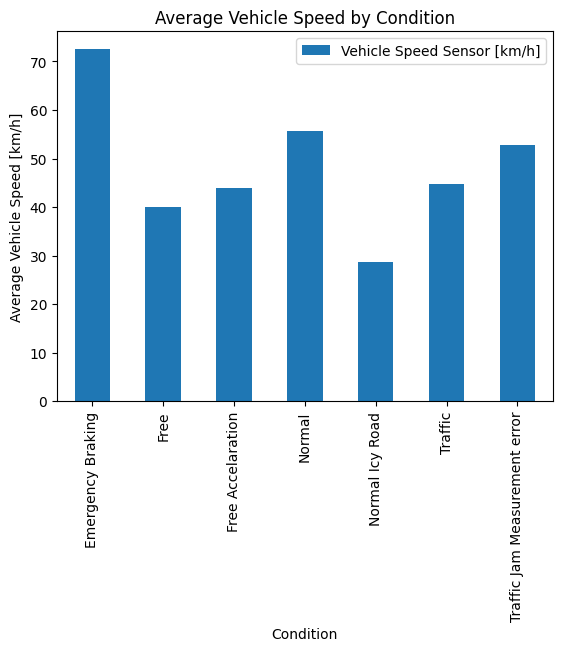

In [127]:
response = query_diagraming_agent("create a bar chart for the various conditions, with the condition being the columns and average vehicle speed being the value")

In [126]:
response

"```python\nimport matplotlib.pyplot as plt\n\npivot_table = df.pivot_table(values='Vehicle Speed Sensor [km/h]', index='condition', aggfunc='mean')\npivot_table.plot(kind='bar')\n\nplt.xlabel('Condition')\nplt.ylabel('Average Vehicle Speed [km/h]')\nplt.title('Average Vehicle Speed by Condition')\nplt.show()\n```"

Given that the diagraming agent is unpredictable, we would be using the python REPL for diagraming

#### Create test agents with dummy tools to test capabilities
In this section, we will create two dummy tools to create both openai function agents, and react agents

In [2]:
from pydantic.v1 import BaseModel, Field

In [3]:
from langchain.tools import tool

The tools we want to use are: 
- dataset question answering
- dataset diagramming
- series prediction
- condition prediction
- afj limited question
- python repl

In [5]:
class DataSetQuestionAnswerSchema(BaseModel):
    """ 
    Schema to be used when asking questions about the dataset
    """
    query:str = Field(description="query question to be asked about the dataset")

In [7]:
@tool("dataset-question-answer", args_schema=DataSetQuestionAnswerSchema, return_direct=True)
def dataset_question_answer(query:str):
    """
    Provides answer to any question asked about the dataset. 
    It takes a natural language question about the dataset and provides a natural language response.
    """
    print("data set question asked")
    # response = query_engine_with_sythesis.query(query)
    # return str(response.response)
    return "data set response"

In [11]:
class DataSetDiagramRequestSchema(BaseModel):
    """
    Schema to used when requesting to draw a diagram from the dataset
    """
    query:str = Field(description="query describing type and nature of diagram to be drawn")
    

In [12]:
@tool("dataset-diagram-request", args_schema=DataSetDiagramRequestSchema, return_direct=False)
def dataset_diagram_request(query: str):
    """ 
    Draws diagram for information about the dataset
    It takes a natural language diagram request and draws the diagram
    """
    # response = query_diagraming_agent(query)
    # return response
    print("calling diagram agent")
    return "diagram info"

    

In [13]:
class VehicleVelocityPredictionSchema(BaseModel):
    engine_coolant_temp: float = Field(description="The engine coolant temperature of the vehicle")
    intake_manifold_pressure: float = Field(description="The Intake manifold absolute pressure of the vehicle")
    engine_rpm: float = Field(description="The engine rpm of the vehicle")
    source: str = Field(description="The source location of the vehicle")
    destination: str = Field(description="The destination location of the vehicle")
    condition: str = Field(description="The condition of the vehicle, must be one of the following: 'Normal','Free', 'Traffic', 'Emergency Braking','Normal Icy Road','Free Accelaration','Traffic Jam Measurement error'")


In [14]:
@tool("predict-vehicle-velocity", args_schema=VehicleVelocityPredictionSchema, return_direct=False)
def predict_vehicle_velocity(engine_coolant_temp, intake_manifold_pressure, engine_rpm, source, destination, condition):
    """ 
    The function allows for predicting the vehicle velocity given the following fields:
    engine coolant temperature, intake manifold pressure, engine rpm, source, destination and condition
    """
    print("velocity prediction function called")
    return "predicted velocity"

In [162]:
class SquareNumberSchema(BaseModel):
    number: float = Field(description="the number to be squared")

In [163]:
@tool("square-number", args_schema=SquareNumberSchema, return_direct=False)
def square_number(number):
    """ 
    This tool is used to find the square of a number
    it takes in  a number as input and returns the square
    """
    number = float(number)
    return "The square of the nummber is " + str(number * number)

In [164]:
tools = [PythonREPLTool(), say_hello, square_number]

In [165]:
test_openai_agent = create_openai_functions_agent(llm, tools, openai_fn_agent_prompt)

In [166]:
agent_executor = AgentExecutor(agent=test_openai_agent, tools=tools, verbose=True)

In [145]:
agent_executor.invoke({"input": "hi!"})



> Entering new AgentExecutor chain...
 Hello! How can I assist you today?

> Finished chain.


{'input': 'hi!', 'output': ' Hello! How can I assist you today?'}

In [147]:
agent_executor.invoke({"input": "Say hello to John Stewart"})



> Entering new AgentExecutor chain...
 [
  {
    "name": "say-hello",
    "arguments": {
      "first_name": "John",
      "last_name": "Stewart"
    }
  }
]

> Finished chain.


{'input': 'Say hello to John Stewart',
 'output': ' [\n  {\n    "name": "say-hello",\n    "arguments": {\n      "first_name": "John",\n      "last_name": "Stewart"\n    }\n  }\n]'}

In [148]:
agent_executor.invoke({"input": "find the square of 7000"})



> Entering new AgentExecutor chain...
 [
  {
    "name": "square-number",
    "arguments": {
      "number": 7000
    }
  }
]

> Finished chain.


{'input': 'find the square of 7000',
 'output': ' [\n  {\n    "name": "square-number",\n    "arguments": {\n      "number": 7000\n    }\n  }\n]'}

In [149]:
agent_executor.invoke({"input": "find the 10th fibonacci number using python"})



> Entering new AgentExecutor chain...
 [
  {
    "name": "Python_REPL",
    "arguments": {
      "__arg1": "def fibonacci(n):\n    if n <= 0:\n        return 0\n    elif n == 1:\n        return 1\n    else:\n        return fibonacci(n-1) + fibonacci(n-2)"
    }
  }
]

> Finished chain.


{'input': 'find the 10th fibonacci number using python',
 'output': ' [\n  {\n    "name": "Python_REPL",\n    "arguments": {\n      "__arg1": "def fibonacci(n):\\n    if n <= 0:\\n        return 0\\n    elif n == 1:\\n        return 1\\n    else:\\n        return fibonacci(n-1) + fibonacci(n-2)"\n    }\n  }\n]'}

The openai function agent is not calling the functions, lets use the react agent instead to see if we can get a more preferred performance

In [169]:
test_react_agent = create_react_agent(llm, tools, react_agent_prompt)

In [170]:
react_agent_executor = AgentExecutor(agent=test_react_agent, tools=tools, verbose=True)

In [172]:
react_agent_executor.invoke({"input": "find the fibonacci of 10 using python"})



> Entering new AgentExecutor chain...
 To find the Fibonacci of a number in Python, I can use a loop to calculate the sequence up to the desired index. However, for larger numbers like 10, it would be more efficient to use a recursive function that utilizes memoization to reduce redundant calculations.

Action: Python_REPL
Action Input:
```python
def fibonacci(n, memo = {}):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    elif n not in memo:
        memo[n] = fibonacci(n - 1) + fibonacci(n - 2)
    return memo[n]

fibonacci(10)
``` Now that I have implemented the Fibonacci function in Python_REPL, I can use it to find the Fibonacci of 10.

Final Answer: 55

> Finished chain.


{'input': 'find the fibonacci of 10 using python', 'output': '55'}

In [174]:
react_agent_executor.invoke({"input": "say hello to John Stewart"})



> Entering new AgentExecutor chain...
 I need to use the "say-hello" tool with the name "John Stewart" as its input.
Action: say-hello
Action Input: John Stewart

ValueError: not enough values to unpack (expected 2, got 1)